# Best (LightGBM) classifier details for ACM ASIACC paper

In [1]:
import pyarrow as pa
import pyarrow.parquet as pq

#phishing = pq.read_table('floor/phishing_2307.parquet')
phishing = pq.read_table('floor/phishing_2311.parquet')
benign = pq.read_table('floor/benign_2310.parquet')

from transformers.drop_nontrain import drop_nontrain_table as drop_nontrain
phishing = drop_nontrain(phishing)
benign = drop_nontrain(benign)

# realign schemas (parquet files save in nonsense orders)
benign = benign.cast(phishing.schema)

# concatentate tables
data = pa.concat_tables([phishing, benign])
df = data.to_pandas()

print(f"Total records: {len(df)}")

from transformers.cast_timestamp import cast_timestamp
df = cast_timestamp(df)

used_features = [

    # IP  ===============================
    # Used in the original NOMS paper
    "ip_mean_average_rtt",
    "ip_entropy",
    "ip_count",
    #"ip_v4_count", "ip_v6_count", # Moved RDAP and RENAMED to rdap_ip
    
    # Newly added for ACM ASIACCS
    "ip_v4_ratio",
    #"ip_a_aaaa_to_all_ratio", <--- not useful for this dataset
    "ip_as_address_entropy",
    "ip_asn_entropy",
    "ip_distinct_as_count",
    
    # DNS  ===============================
    # Used in the original NOMS paper
    "dns_A_count",
    "dns_AAAA_count",
    "dns_MX_count",
    "dns_NS_count",
    #"dns_SOA_count", <-- REMOVED, very low effect -------------------------------------
    "dns_TXT_count",
    "dns_CNAME_count",
    "dns_soa_primary_ns_len",
    "dns_soa_primary_ns_level", # renamed
    "dns_soa_primary_ns_digit_count",
    "dns_soa_primary_ns_entropy",
    "dns_soa_email_len",
    "dns_soa_email_level", # renamed
    "dns_soa_email_digit_count",
    "dns_soa_email_entropy",
    # "dns_soa_serial", <-- Doesn't convey any kind of comparative information
    "dns_soa_refresh",
    "dns_soa_retry",
    "dns_soa_expire",
    "dns_mx_avg_len",
    "dns_mx_avg_entropy",
    "dns_domain_name_in_mx",
    "dns_txt_spf_exists",
    "dns_txt_avg_entropy",
    "dns_txt_dkim_exists",
    
    "dns_zone_level",
    "dns_zone_digit_count",
    "dns_zone_len",
    "dns_zone_entropy",
    
    # Newly added for ACM ASIACCS
    "dns_resolved_record_types",
    "dns_has_dnskey",
    "dns_dnssec_score",
    "dns_ttl_avg",
    "dns_ttl_stdev",
    "dns_ttl_low",
    "dns_ttl_mid",
    "dns_ttl_distinct_count",
    "dns_soa_min_ttl", # why is this not in NOMS?!
    "dns_txt_external_verification_score",
    "dns_txt_dmarc_exists",
    
    
    # TLS  ===============================
    # Used in the original NOMS paper
    "tls_broken_chain",
    "tls_expired_chain",
    "tls_is_self_signed", # <--- NEW (23-12-02)
    "tls_root_authority_hash", # <--- NEW (23-12-02)
    "tls_leaf_authority_hash", # <--- NEW (23-12-02)
    "tls_total_extension_count",
    "tls_critical_extensions",
    "tls_with_policies_crt_count",
    "tls_percentage_crt_with_policies",
    "tls_x509_anypolicy_crt_count",
    "tls_iso_policy_crt_count",
    "tls_joint_isoitu_policy_crt_count",
    # "tls_iso_policy_oid", <-- Basically a random value, doesn't make much sense when collected like this; policy OIDs need more research
    # "tls_isoitu_policy_oid", <-- same
    #"tls_unknown_policy_crt_count", <-- Abandoned, no useful values
    "tls_root_cert_validity_len",
    "tls_leaf_cert_validity_len",
    "tls_chain_len",
    #"tls_root_cert_lifetime", <---- NO!
    #"tls_leaf_cert_lifetime", <---- NO!
    "tls_subject_count",
    "tls_unique_SLD_count",
    "tls_server_auth_crt_count",
    "tls_client_auth_crt_count",
    "tls_CA_certs_in_chain_ratio",
    "tls_common_name_count",
    
    # Newly added for ACM ASIACCS
    #"tls_has_tls", , <-- REMOVED, very low effect -------------------------------------
    "tls_negotiated_version_id",
    "tls_negotiated_cipher_id",
    
    # LEX ===============================
    # Used in the original NOMS paper
    "lex_name_len",
    #"lex_digit_count", <-- abandoned, almost the same as "lex_sub_digit_ratio"
    "lex_has_digit",
    "lex_phishing_keyword_count",
    #"lex_vowel_count", <-- moved to sub
    #"lex_underscore_hyphen_count", <--- same as nonalnum
    "lex_consecutive_chars",
    "lex_tld_len",
    "lex_tld_abuse_score", # *************************************************************
    "lex_tld_hash", # *************************************************************
    
    "lex_sld_len",
    "lex_sld_norm_entropy", # <-- newly added feature on 23-09-29
    # ============================= New SLD features 23-11
    "lex_sld_phishing_keyword_count",
    #"lex_sld_digit_count",
    #"lex_sld_digit_ratio",
    "lex_sld_vowel_count",
    "lex_sld_vowel_ratio",
    "lex_sld_consonant_count",
    "lex_sld_consonant_ratio",
    "lex_sld_non_alphanum_count",
    "lex_sld_non_alphanum_ratio",
    "lex_sld_hex_count",
    "lex_sld_hex_ratio",
    # =============================      
    
    "lex_sub_count",
    "lex_stld_unique_char_count",
    "lex_begins_with_digit",
    "lex_www_flag",
    "lex_sub_max_consonant_len",
    "lex_sub_norm_entropy",
    "lex_sub_digit_count",
    "lex_sub_digit_ratio",
    "lex_sub_consonant_ratio",
    "lex_sub_non_alphanum_ratio",
    "lex_sub_hex_ratio",

    #"lex_bigram_matches",  # OLD NAME
    #"lex_trigram_matches", # OLD NAME
    "lex_phishing_bigram_matches",  # NEW NAME
    "lex_phishing_trigram_matches", # NEW NAME
    "lex_phishing_tetragram_matches", # *************************************************************
    "lex_phishing_pentagram_matches", # *************************************************************
    "lex_sub_vowel_count",
    "lex_sub_vowel_ratio",
    "lex_sub_consonant_count",
    "lex_sub_non_alphanum_count",
    "lex_sub_hex_count",
    "lex_avg_part_len",
    "lex_stdev_part_lens",
    "lex_longest_part_len",
    "lex_shortest_sub_len",
    
    # RDAP ===============================
    # Used in the original NOMS paper
    "rdap_registration_period",
    "rdap_domain_age",
    "rdap_time_from_last_change",
    "rdap_domain_active_time",
    "rdap_has_dnssec",
    "rdap_ip_v4_count", "rdap_ip_v6_count", # <-- used for NOMS, but now prefixed with rdap_
    
    # Newly added for ACM ASIACCS
    "rdap_registrar_name_len",
    "rdap_registrar_name_entropy",
    "rdap_registrar_name_hash",
    "rdap_registrant_name_len",
    "rdap_registrant_name_entropy",
    "rdap_admin_name_len",
    "rdap_admin_name_entropy",
    "rdap_admin_email_len",
    "rdap_admin_email_entropy",
    
    "rdap_ip_shortest_v4_prefix_len",
    "rdap_ip_longest_v4_prefix_len",
    "rdap_ip_shortest_v6_prefix_len",
    "rdap_ip_longest_v6_prefix_len",
    
    "rdap_ip_avg_admin_name_len",
    "rdap_ip_avg_admin_name_entropy",
    "rdap_ip_avg_admin_email_len",
    "rdap_ip_avg_admin_email_entropy",
    
    # GEO ===============================
    # Used in the original NOMS paper
    "geo_countries_count",
    "geo_continent_hash",
    "geo_countries_hash",
    
    # Newly added for ACM ASIACCS
    "geo_lat_stdev", # <- Puvodne to pridal Adam, ale pak jsme dali pryc, ze to budem resit jinak.
    "geo_lon_stdev",  #    Ale muze byt helpful pro identifikaci, jestli lokality jsou blizko sebe.    
    #"geo_min_lat", # not very useful
    #"geo_max_lat", # not very useful
    #"geo_min_lon", # not very useful
    #"geo_max_lon", # not very useful
    "geo_mean_lat", # *************************************************************
    "geo_mean_lon", # *************************************************************
    #"geo_lat_range", # not very useful
    #"geo_lon_range", # not very useful
    "geo_centroid_lat", # *************************************************************
    "geo_centroid_lon", # *************************************************************
    #"geo_estimated_area",  # not very useful 
]


print("Number of used features: " + str(len(used_features)))

# NUMBER OF AVAILABLE AND UNUSED FEATURES
missing_columns = set(df.columns) - set(used_features) - set(["label"])
print("No. of available unused features: " + str(len(missing_columns)))

df = df[["label", *used_features]]


Total records: 500925
Number of used features: 143
No. of available unused features: 34


## Supressing unwanted warnings (futures etc.)

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn.*')
warnings.filterwarnings('ignore', category=FutureWarning, module='xgboost.*')
warnings.filterwarnings('ignore', message="Series.__getitem__ treating keys as positions is deprecated.*")

## Shortening feature names (for paper purposes)

In [3]:
shortening = {
    "lex_stld_unique_char_count": "lex_stld_uniq_char_cnt",
    "lex_sub_max_consonant_len": "lex_max_conson_len",
    "lex_sub_non_alphanum_count": "lex_sub_nonalnum_count",
    "lex_sub_non_alphanum_ratio": "lex_sub_nonalnum_ratio",
    "lex_phishing_keyword_count": "lex_phishing_kw_count",
    "lex_sld_phishing_keyword_count": "lex_sld_phishing_kw_count",
    
    "dns_resolved_record_types": "dns_resolved_rec_types",
    "dns_domain_name_in_mx": "dns_dn_in_mx",
    "dns_txt_external_verification_score": "dns_txt_ext_verif_score",
    "dns_zone_digit_count": "dns_zone_digits",
    "dns_soa_primary_ns_digit_count": "dns_soa_prim_ns_digits",
    "dns_soa_primary_ns_len" : "dns_soa_pri_ns_len",
    "dns_soa_primary_ns_level": "dns_soa_pri_ns_level",
    "dns_soa_primary_ns_entropy": "dns_soa_pri_ns_entropy",
    "dns_soa_email_digit_count": "dns_soa_email_digits",
    
    "tls_percentage_crt_with_policies": "tls_percentage_with_policies",
    "tls_x509_anypolicy_crt_count": "tls_x509_anypol_crt_count",
    "tls_iso_policy_crt_count": "tls_iso_pol_crt_count",
    "tls_joint_isoitu_policy_crt_count": "tls_isoitu_pol_crt_count",
    
    "rdap_ip_avg_admin_name_entropy": "rdap_ip_avg_admin_name_ent",
    "rdap_ip_avg_admin_email_entropy": "rdap_ip_avg_admin_email_ent"
}

df.rename(columns=shortening, inplace=True)

df

,label,ip_mean_average_rtt,ip_entropy,ip_count,ip_v4_ratio,ip_as_address_entropy,ip_asn_entropy,ip_distinct_as_count,dns_A_count,dns_AAAA_count,...,rdap_ip_avg_admin_email_ent,geo_countries_count,geo_continent_hash,geo_countries_hash,geo_lat_stdev,geo_lon_stdev,geo_mean_lat,geo_mean_lon,geo_centroid_lat,geo_centroid_lon
0,misp_2310:phishing,0.000000,-0.000000,1,1.0,-0.000000,-0.000000,1.0,1,0,...,0.000000,1,3,184,0.00000,0.0000,50.45220,30.5287,75.67830,45.79305
1,misp_2310:phishing,-1.000000,-0.000000,0,0.0,NaN,NaN,NaN,0,0,...,0.000000,0,0,0,0.00000,0.0000,0.00000,0.0000,0.00000,0.00000
2,misp_2310:phishing,0.000000,-0.000000,1,1.0,-0.000000,-0.000000,1.0,1,0,...,0.000000,1,0,144,0.00000,0.0000,55.73860,37.6068,83.60790,56.41020
3,misp_2310:phishing,-1.000000,-0.000000,0,0.0,NaN,NaN,NaN,0,0,...,0.000000,0,0,0,0.00000,0.0000,0.00000,0.0000,0.00000,0.00000
4,misp_2310:phishing,-1.000000,-0.000000,0,0.0,NaN,NaN,NaN,0,0,...,0.000000,0,0,0,0.00000,0.0000,0.00000,0.0000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500920,benign_2310:unknown,43.488625,4.240224,16,1.0,4.106891,1.061278,3.0,2,0,...,0.157633,1,1,187,0.00000,0.0000,37.75100,-97.8220,56.62650,-146.73300
500921,benign_2310:unknown,3.996786,4.186138,14,0.5,3.900424,0.734530,3.0,1,1,...,0.190507,1,1,187,0.00000,0.0000,39.10270,-94.5778,58.65405,-141.86670
500922,benign_2310:unknown,4.329750,4.000000,12,1.0,2.000000,-0.000000,1.0,2,0,...,0.149881,1,5,86,0.00000,0.0000,35.68930,139.6899,53.53395,209.53485
500923,benign_2310:unknown,16.280900,4.643856,10,0.5,3.043856,0.721928,2.0,1,1,...,0.179189,1,3,65,1.19615,2.3587,51.32345,11.0482,76.38710,15.39295


# NaNs will be replaced by -1
## Some classifiers cannot handle NaN values
Replacing by -1 gave better results (for xgboost) than 0

In [4]:
# Handle NaNs
df.fillna(-1, inplace=True)

# Train-Test split

In [5]:
from config import Config
from sklearn.model_selection import train_test_split

class_map = {"benign_2310:unknown": 0, "misp_2310:phishing": 1}

labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix

X_train, X_test, y_train, y_test = train_test_split(
  features,
  labels,
  test_size=0.3,
  random_state=42,
  shuffle=True, 
  stratify=labels
)

# LightGBM

In [25]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# LightGBM parameters
params = {
    "objective": "binary",  # binary classification
    "boosting_type": "gbdt",  # Gradient Boosting Decision Tree
    "n_estimators": 897, # Number of boosted trees to fit, equivalent to number of boosting iterations
    "num_leaves": 59,
    "max_depth": 17,
    "learning_rate": 0.15,
    "objective": "binary",
    "min_child_samples": 27,
    "colsample_bytree": 0.9,
    "reg_lambda": 0.11,
    "scale_pos_weight": 6.28, # default: 1.0
    "subsample_for_bin": 240000,
    "random_state": 7,
}


model = lgb.LGBMClassifier(**params, metric=['error', 'binary_logloss', 'auc'])

# set to True to cross validate
do_cross_val = False
if do_cross_val:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
    print("F1: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# at last, train the model
#_ = model.fit(X_train, y_train)

# at last, train the model
eval_set = [(X_train, y_train), (X_test, y_test)]
_ = model.fit(X_train, y_train, eval_set=eval_set)


#
import pickle
pickle.dump(model, open("lgbm_phishing.pkl", "wb"))




[LightGBM] [Info] Number of positive: 47847, number of negative: 302800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13500
[LightGBM] [Info] Number of data points in the train set: 350647, number of used features: 143
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.136453 -> initscore=-1.845064
[LightGBM] [Info] Start training from score -1.845064


# Classifier Validation

dict_keys(['training', 'valid_1'])
Training metrics: odict_keys(['binary_logloss', 'auc'])
Validation metrics: odict_keys(['binary_logloss', 'auc'])


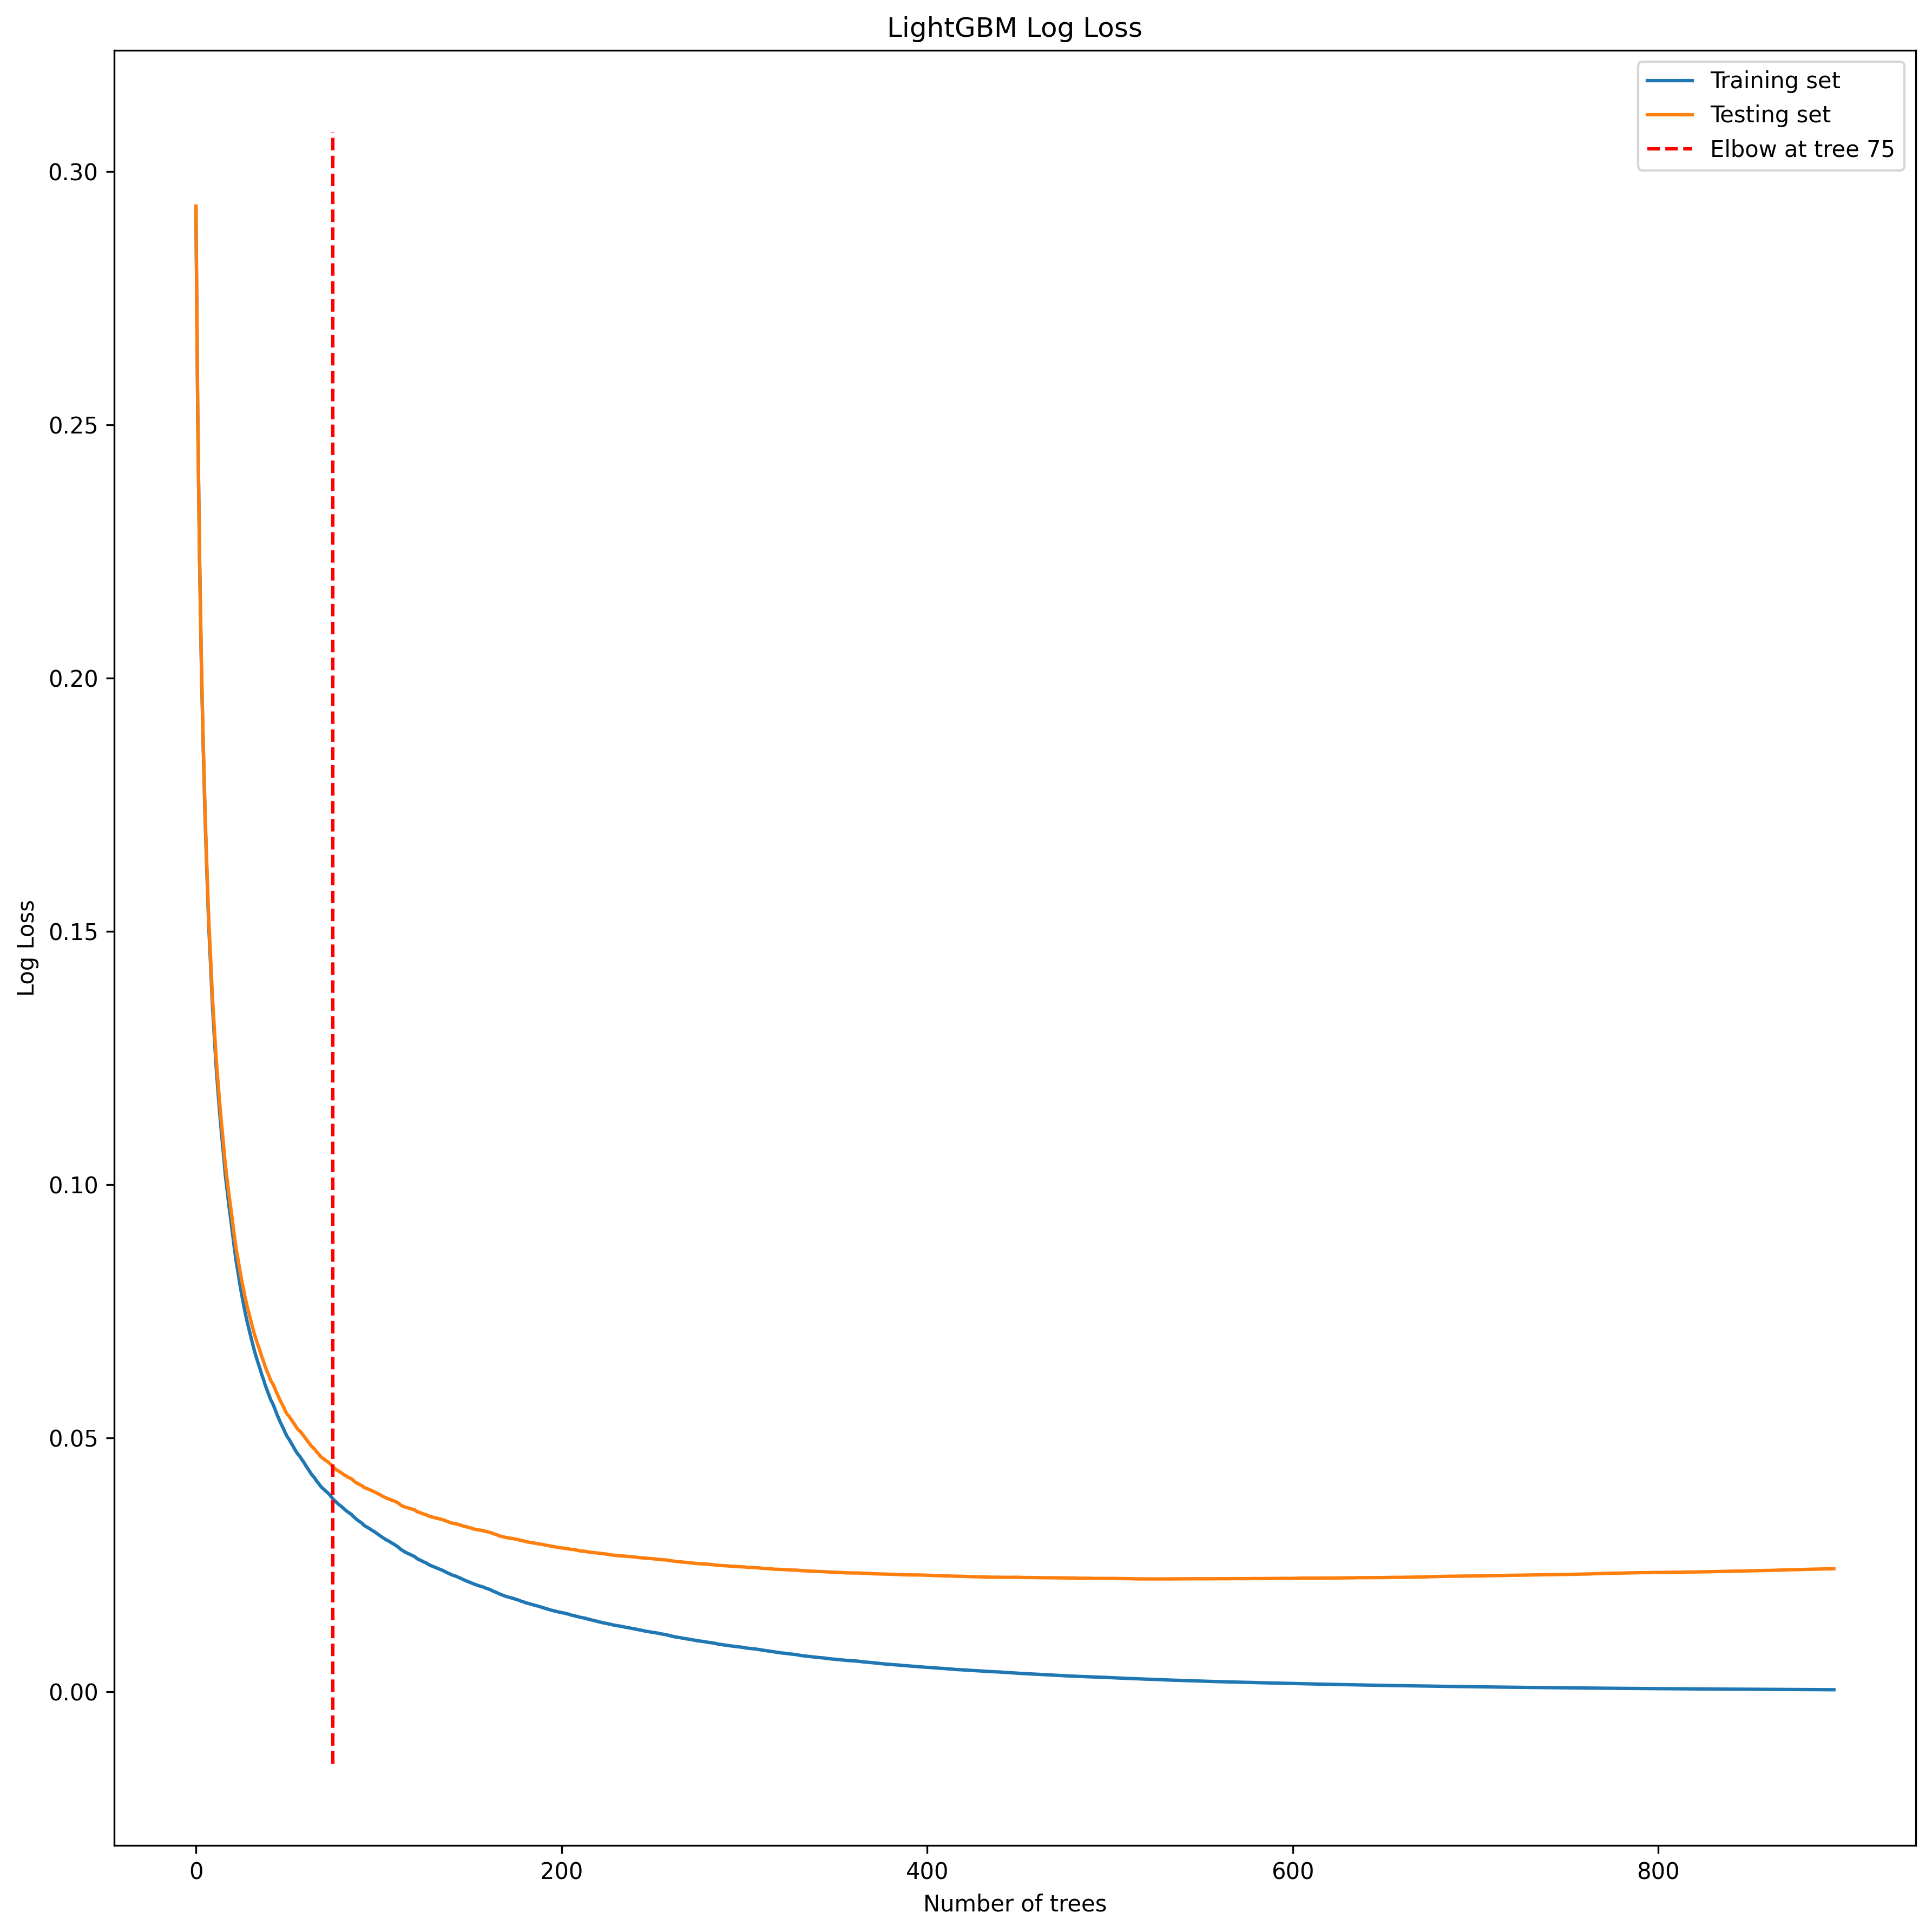

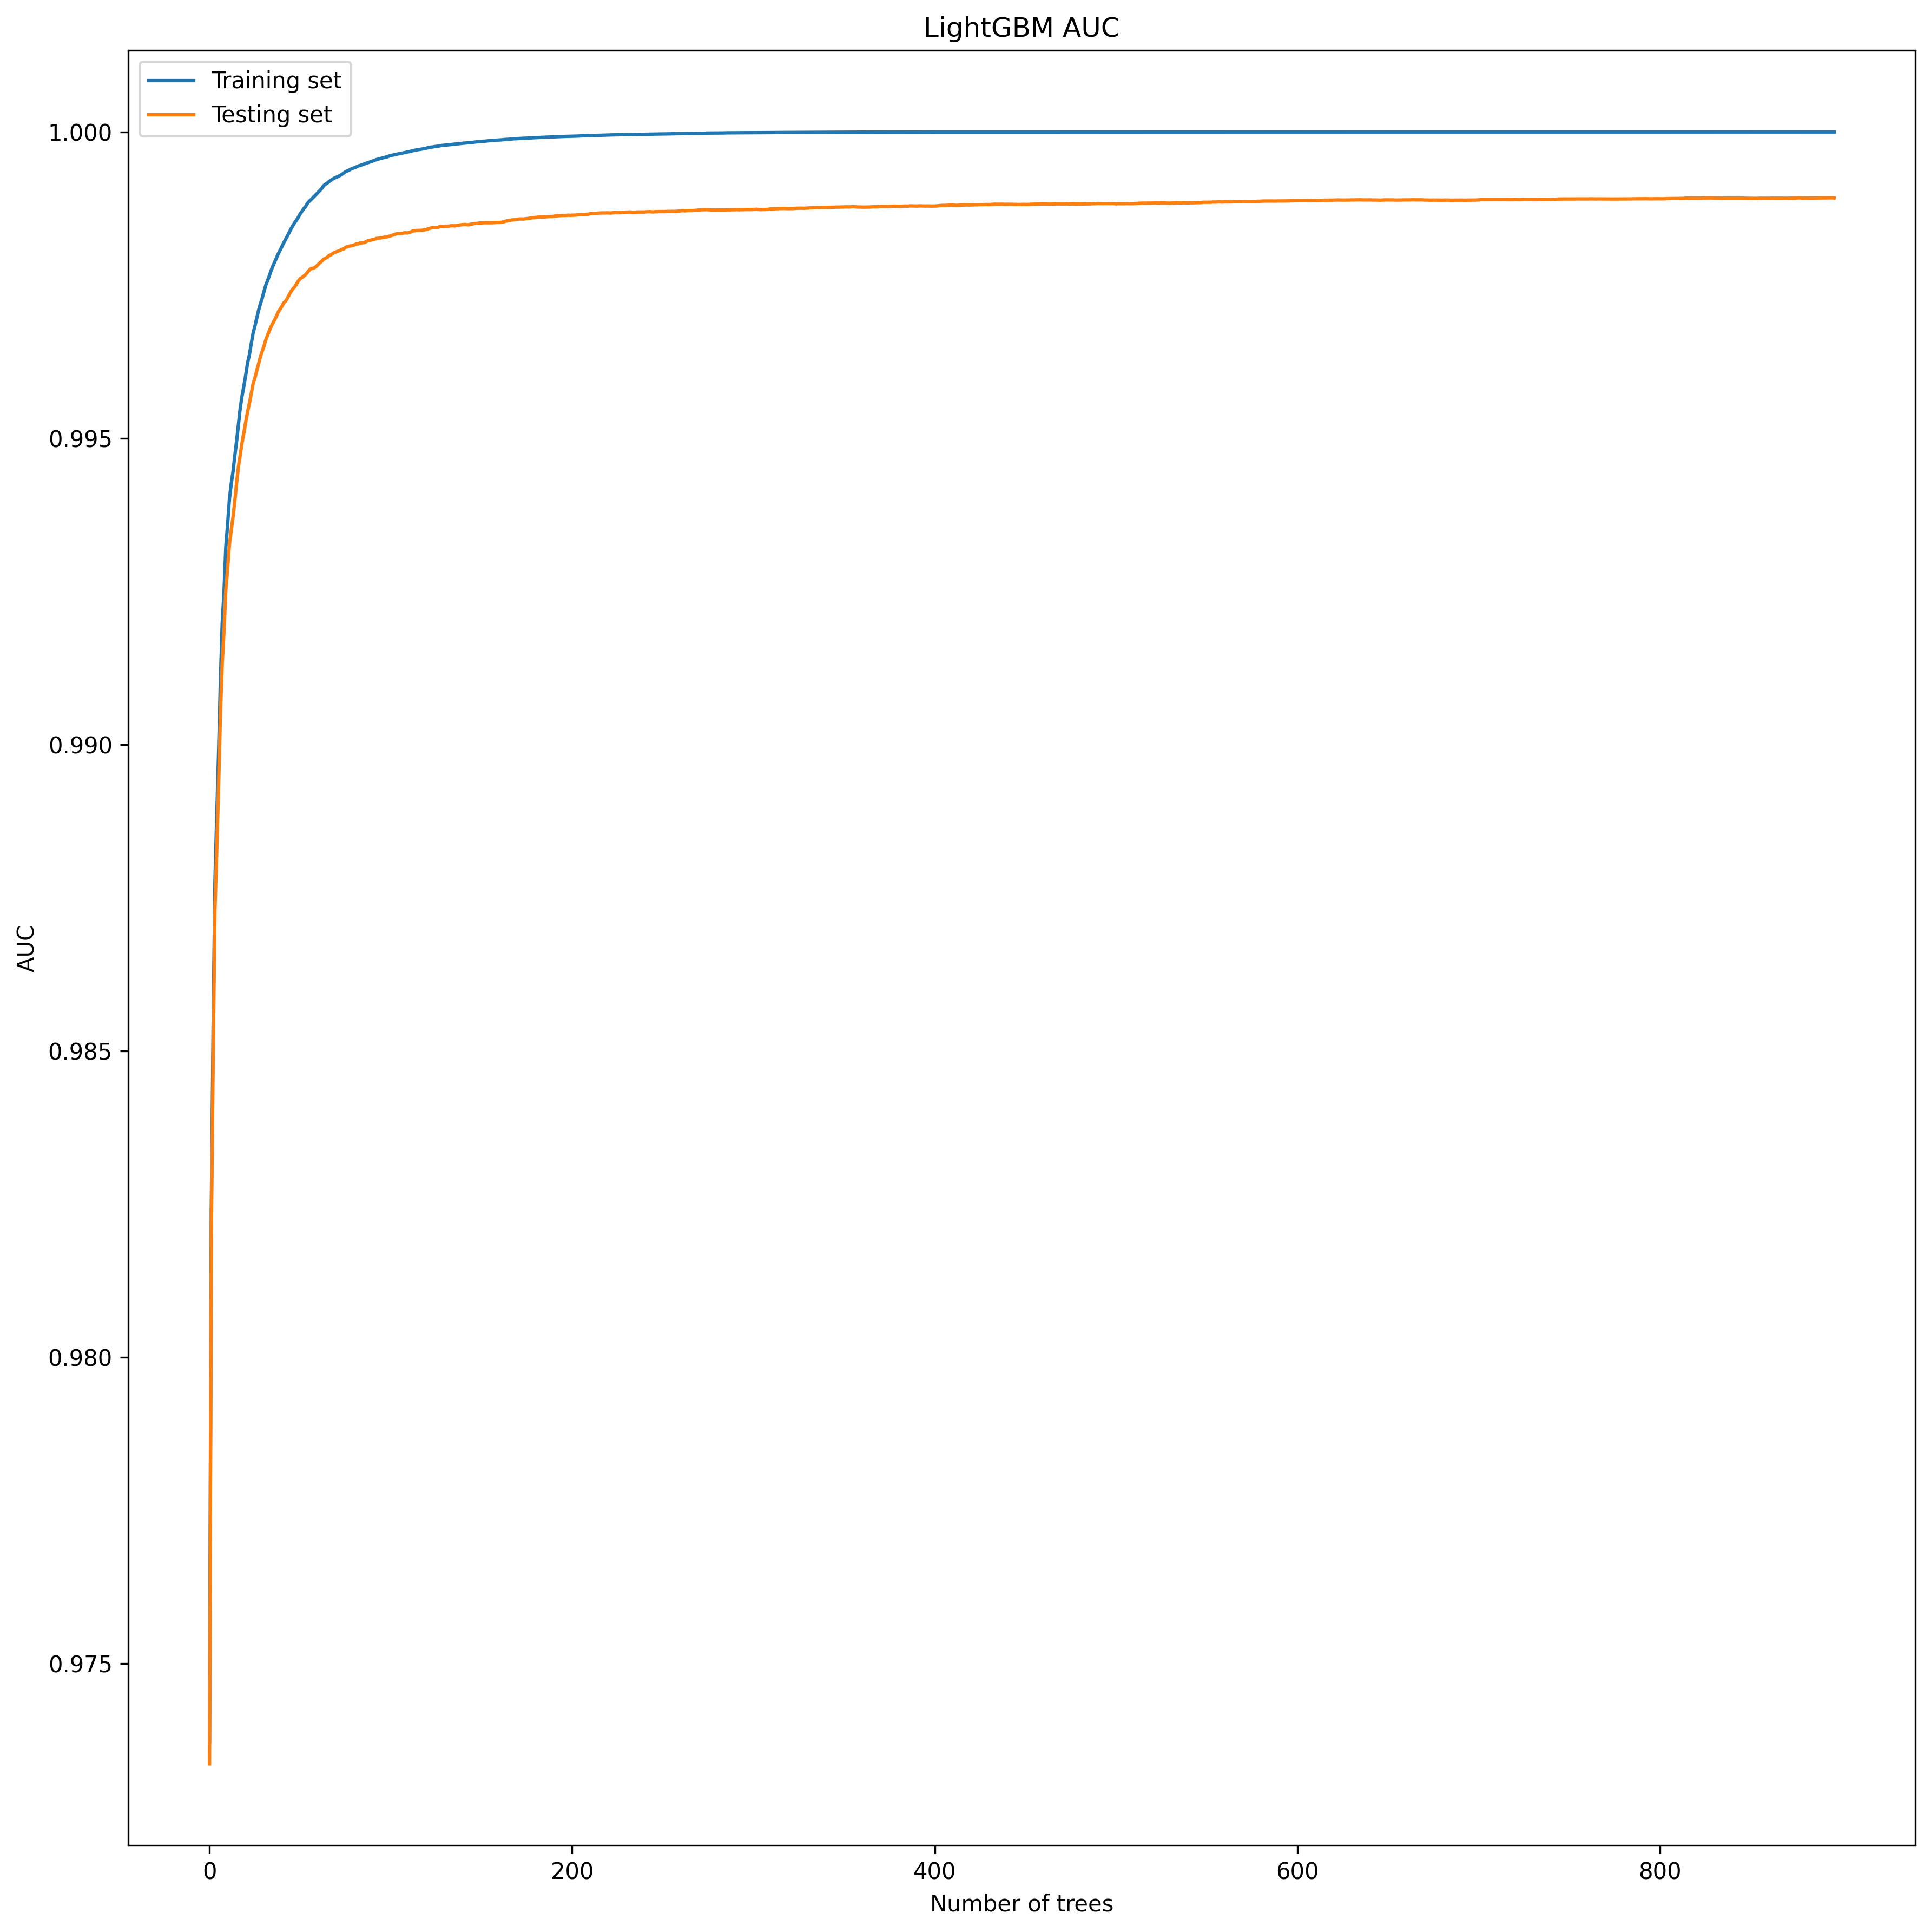

Accuracy: 0.99
Precision: 0.98
Recall: 0.97
F1 Score: 0.98
              precision    recall  f1-score   support

           0     0.9955    0.9973    0.9964    129772
           1     0.9828    0.9715    0.9771     20506

    accuracy                         0.9938    150278
   macro avg     0.9891    0.9844    0.9867    150278
weighted avg     0.9938    0.9938    0.9938    150278

TN: 129423 <-- True Negatives
FP: 349 <-- False Positives
FN: 585 <-- False Negatives
TP: 19921 <-- True Positives
FPR:0.00268933205930401 <-- False Positive Rate
TPR:0.9714717643616503 <-- True Positive Rate (same as Recall)


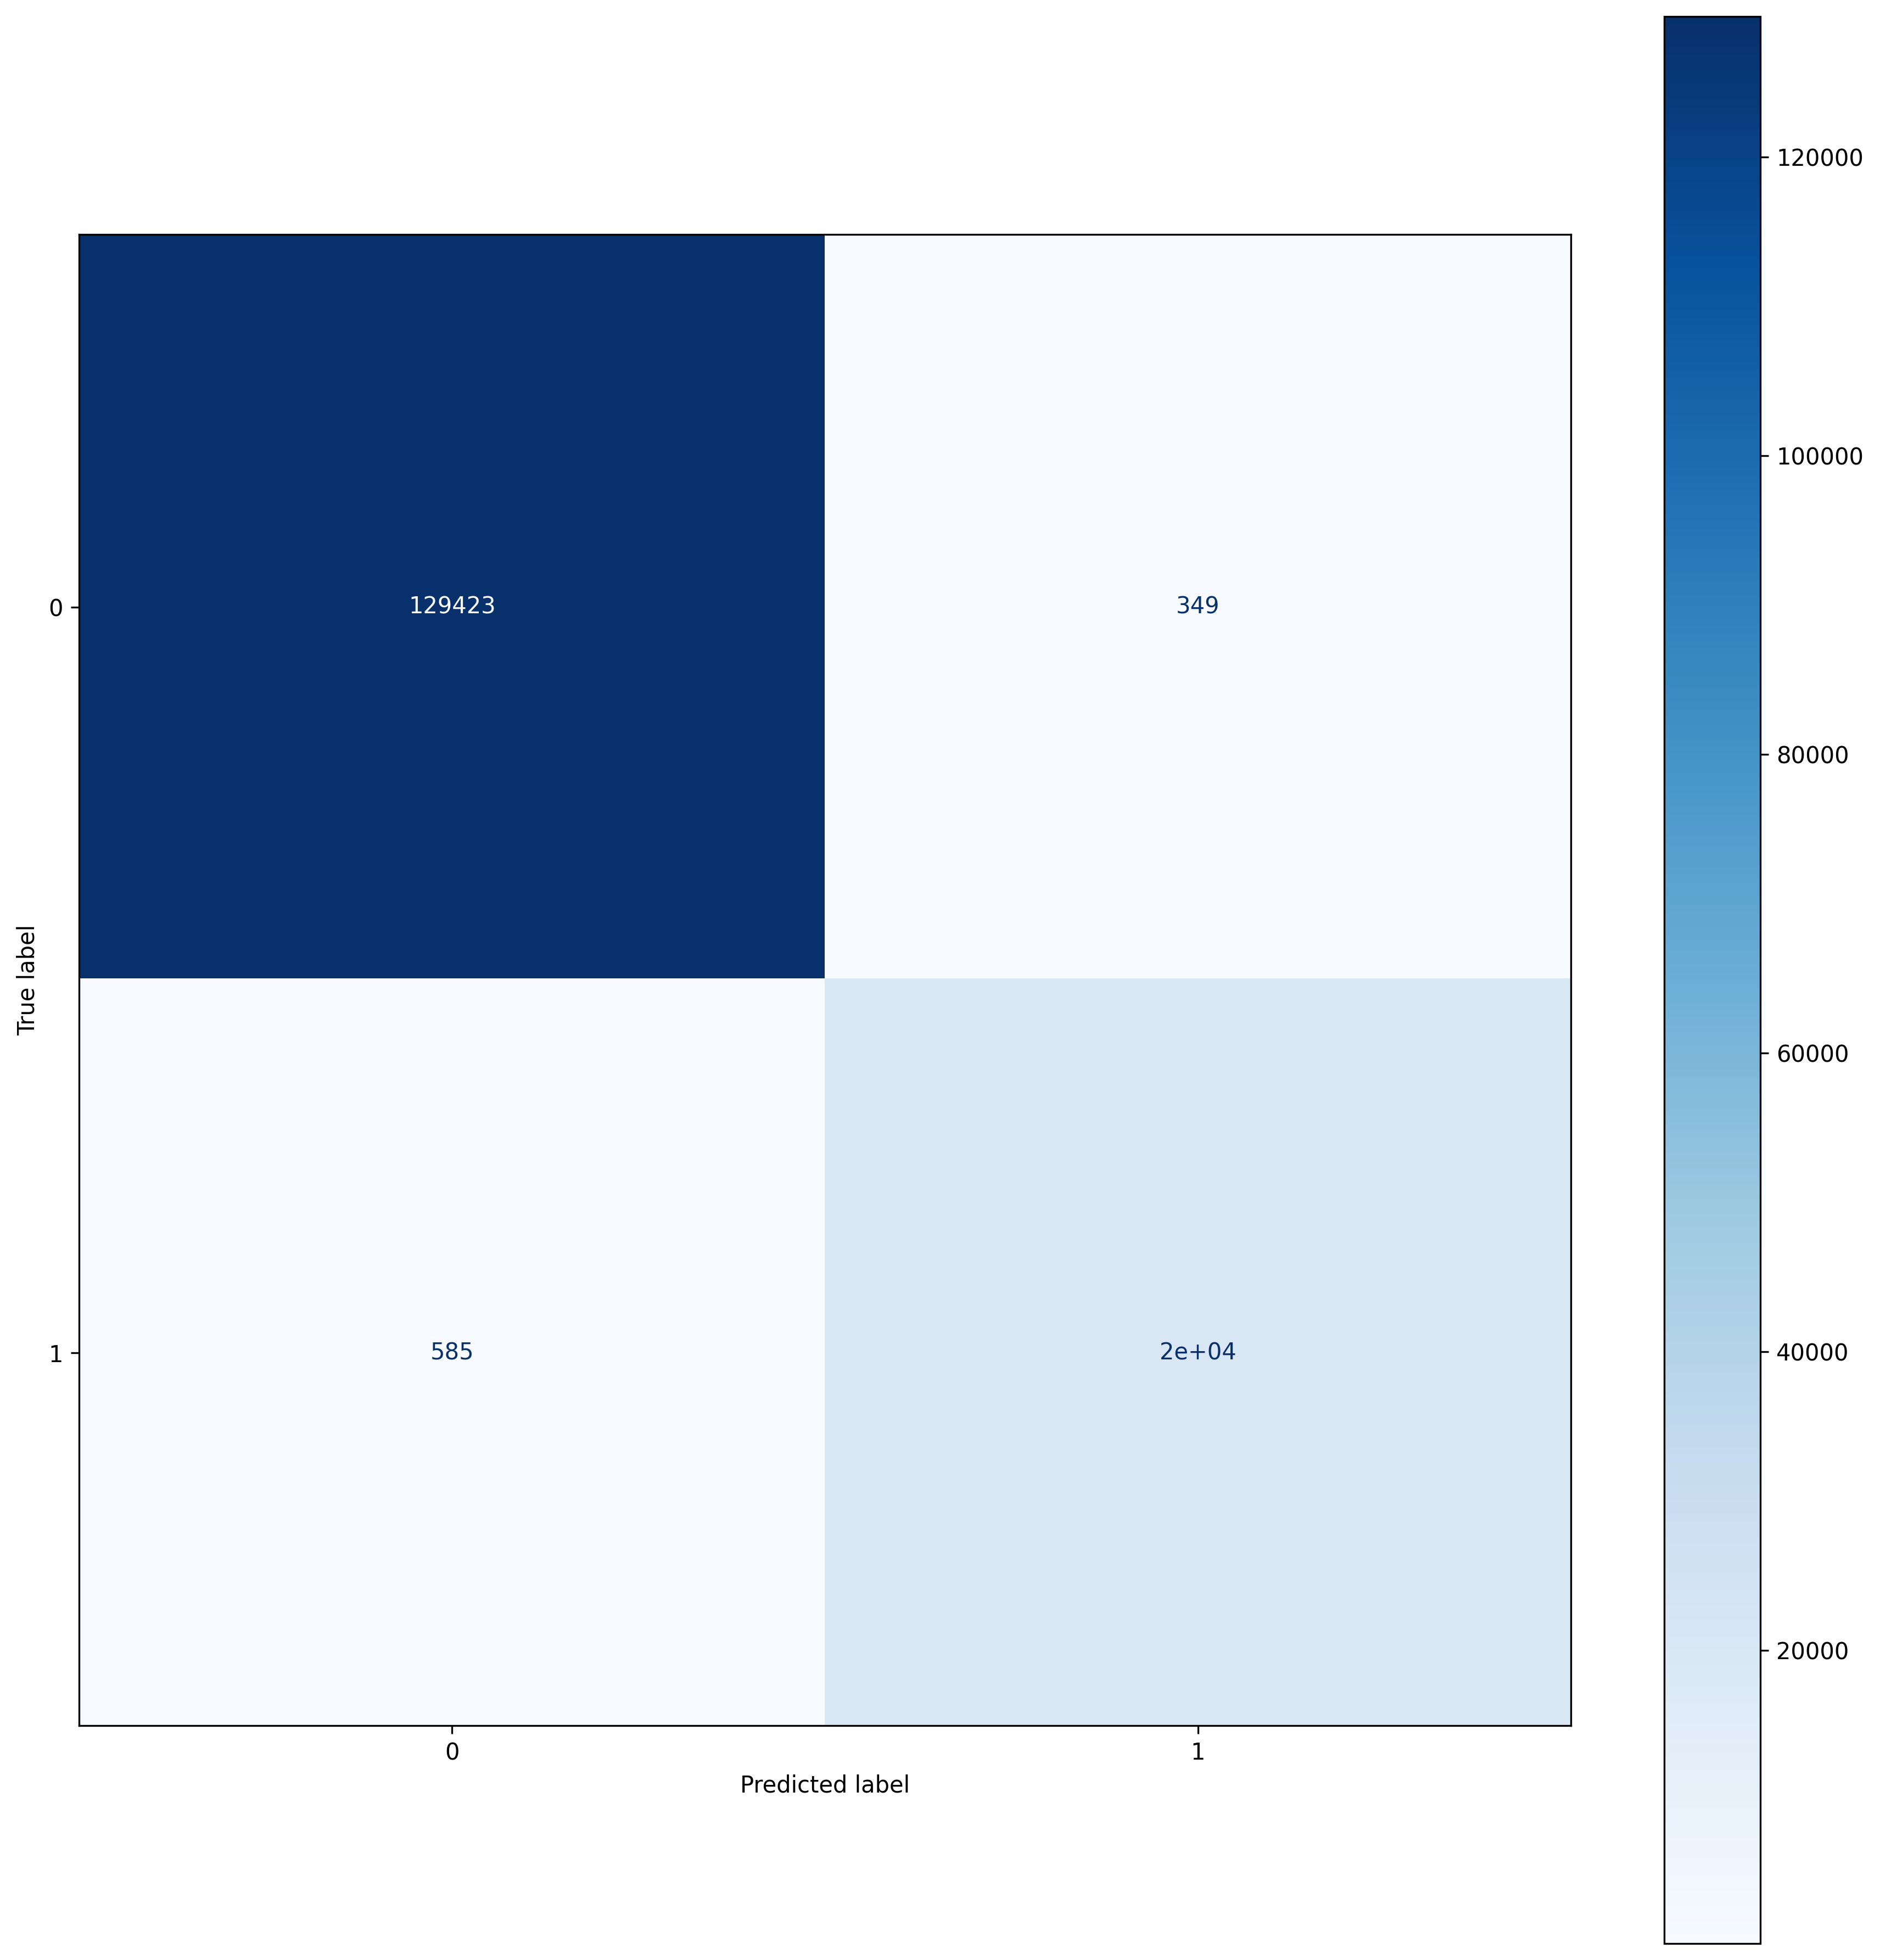

In [26]:
from kneed import KneeLocator

results = model.evals_result_
print(results.keys())

print("Training metrics:", results['training'].keys())
print("Validation metrics:", results['valid_1'].keys())

trees = len(results['valid_1']['binary_logloss'])  # Using 'error' as an example metric here
x_axis = range(0, trees)

def plot_metric(metric):
    plt.rcParams["figure.dpi"] = 300
    
    # Plot metric curves
    plt.plot(x_axis, results['training'][metric], label='Training set')
    plt.plot(x_axis, results['valid_1'][metric], label='Testing set')
    
    # Detect elbow using Kneedle algorithm
    kn = KneeLocator(x_axis, results['valid_1'][metric], curve='convex', direction='decreasing')
    if kn.knee:
        plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label='Elbow at tree ' + str(kn.knee))
    
    plt.legend()
    mnames = {'error': 'Classification Error', 'binary_logloss': 'Log Loss', 'auc': 'AUC'}
    mname = mnames.get(metric, metric)  # Return the metric itself if it's not in the dictionary
    plt.ylabel(mname)
    plt.xlabel('Number of trees')
    plt.title('LightGBM ' + mname)
    plt.show()

#plot_metric('error')
plot_metric('binary_logloss')  # Note: LightGBM uses 'binary_logloss' instead of 'logloss' for binary classification
plot_metric('auc')


# Evaluate the model on the test set
y_pred = model.predict(X_test)


print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(f'Precision: {precision_score(y_test, y_pred, zero_division=1):.2f}')
print(f'Recall: {recall_score(y_test, y_pred):.2f}')
print(f'F1 Score: {f1_score(y_test, y_pred):.2f}')


from sklearn.metrics import classification_report, ConfusionMatrixDisplay, det_curve
print(classification_report(y_test, y_pred, digits=4))

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)  # Compute confusion matrix

#conf_matrix = confusion_matrix(y_test, predicted)
tn, fp, fn, tp = cm.ravel()

# Calculate False Positive Rate (FPR)
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)

print("TN: " + str(tn) + " <-- True Negatives")
print("FP: " + str(fp) + " <-- False Positives")
print("FN: " + str(fn) + " <-- False Negatives")
print("TP: " + str(tp) + " <-- True Positives")

print("FPR:" + str(fpr) + " <-- False Positive Rate")
print("TPR:" + str(tpr) + " <-- True Positive Rate (same as Recall)")

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)  # Create display object
disp.plot(cmap=plt.cm.Blues)  # Plot confusion matrix
plt.show()  # Show the plot



# Hyperparameter Tuning

## Custom Metric
Allow for setting weights for **Precision, F1, FPR, logloss** and **Overfitting** (difference between train and test scores).
* If you want to use it, the **scoring** should be set to **FETA_Score** on hyperparameter tuning.
* Otherwise, you can set **scoring** to metric you want: **neg_log_loss**, **precision**, **f1**, etc.

In [15]:
from sklearn.metrics import precision_score, f1_score, confusion_matrix, log_loss

def FETA_Score(estimator, X, y):
    # Getting predictions
    y_pred = estimator.predict(X)
    y_pred_proba = estimator.predict_proba(X)
    
    # Calculating precision
    precision = precision_score(y, y_pred)
    
    # Calculating recall
    recall = recall_score(y, y_pred)
    
    # Calculating F1-score
    f1 = f1_score(y, y_pred)
    
    # Calculating FPR
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    # Calculating Log Loss
    logloss = log_loss(y, y_pred_proba)
    
    # Estimating overfitting
    train_score = estimator.score(X_train, y_train) 
    validation_score = estimator.score(X, y) 
    overfitting = train_score - validation_score
    
    # Assigning weights
    w_precision = 0.1     # Precision
    w_recall = 0.2        # Recall
    w_f1 = 0.6            # F1
    w_fpr = -0.0          # Negative because lower FPR is better
    w_logloss = -0.0      # Negative because lower log loss is better
    w_overfitting = -0.1  # Negative because lower overfitting is better
    
    #w_precision = 0.0     # Precision
    #w_recall = 0.5        # Recall
    #w_f1 = 0.5            # F1
    #w_fpr = -0.0          # Negative because lower FPR is better
    #w_logloss = -0.1      # Negative because lower log loss is better
    #w_overfitting = -0.0  # Negative because lower overfitting is better
    
    # Assigning weights
    #w_precision = 0.1     # Precision
    #w_recall = 0.1        # Recall
    #w_f1 = 0.4            # F1
    #w_fpr = -0.1          # Negative because lower FPR is better
    #w_logloss = -0.1      # Negative because lower log loss is better
    #w_overfitting = -0.5  # Negative because lower overfitting is better
    
    # Combining metrics with weights
    combined_score = (w_precision * precision + w_recall * recall + w_f1 * f1 + w_fpr * fpr + w_overfitting * overfitting)
    
    return combined_score


## Grid Search for finding the optimal settings

This code allows you to test different combinations of hyperparameters to find the most fitting combination for the desired scoring metric. You should:

* Set **run_grid_search** to **True**.
* Set **params** to fixed parameters (that remain constant).
* Set **grid** to desired values of variable parameters.
* Set **n_splits** to at least 3, ideally 5.

Fitting 2 folds for each of 7 candidates, totalling 14 fits
[LightGBM] [Info] Number of positive: 23923, number of negative: 151400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13273
[LightGBM] [Info] Number of data points in the train set: 175323, number of used features: 143
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.136451 -> initscore=-1.845085
[LightGBM] [Info] Start training from score -1.845085
[CV 1/2] END scale_pos_weight=6.1;, score=(train=0.900, test=0.874) total time=  16.1s
[LightGBM] [Info] Number of positive: 23924, number of negative: 151400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

[CV 1/2] END scale_pos_weight=7;, score=(train=0.900, test=0.874) total time=  16.1s
[LightGBM] [Info] Number of positive: 23924, number of negative: 151400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13297
[LightGBM] [Info] Number of data points in the train set: 175324, number of used features: 143
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.136456 -> initscore=-1.845043
[LightGBM] [Info] Start training from score -1.845043
[CV 2/2] END scale_pos_weight=7;, score=(train=0.900, test=0.874) total time=  16.4s
[LightGBM] [Info] Number of positive: 47847, number of negative: 302800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you c

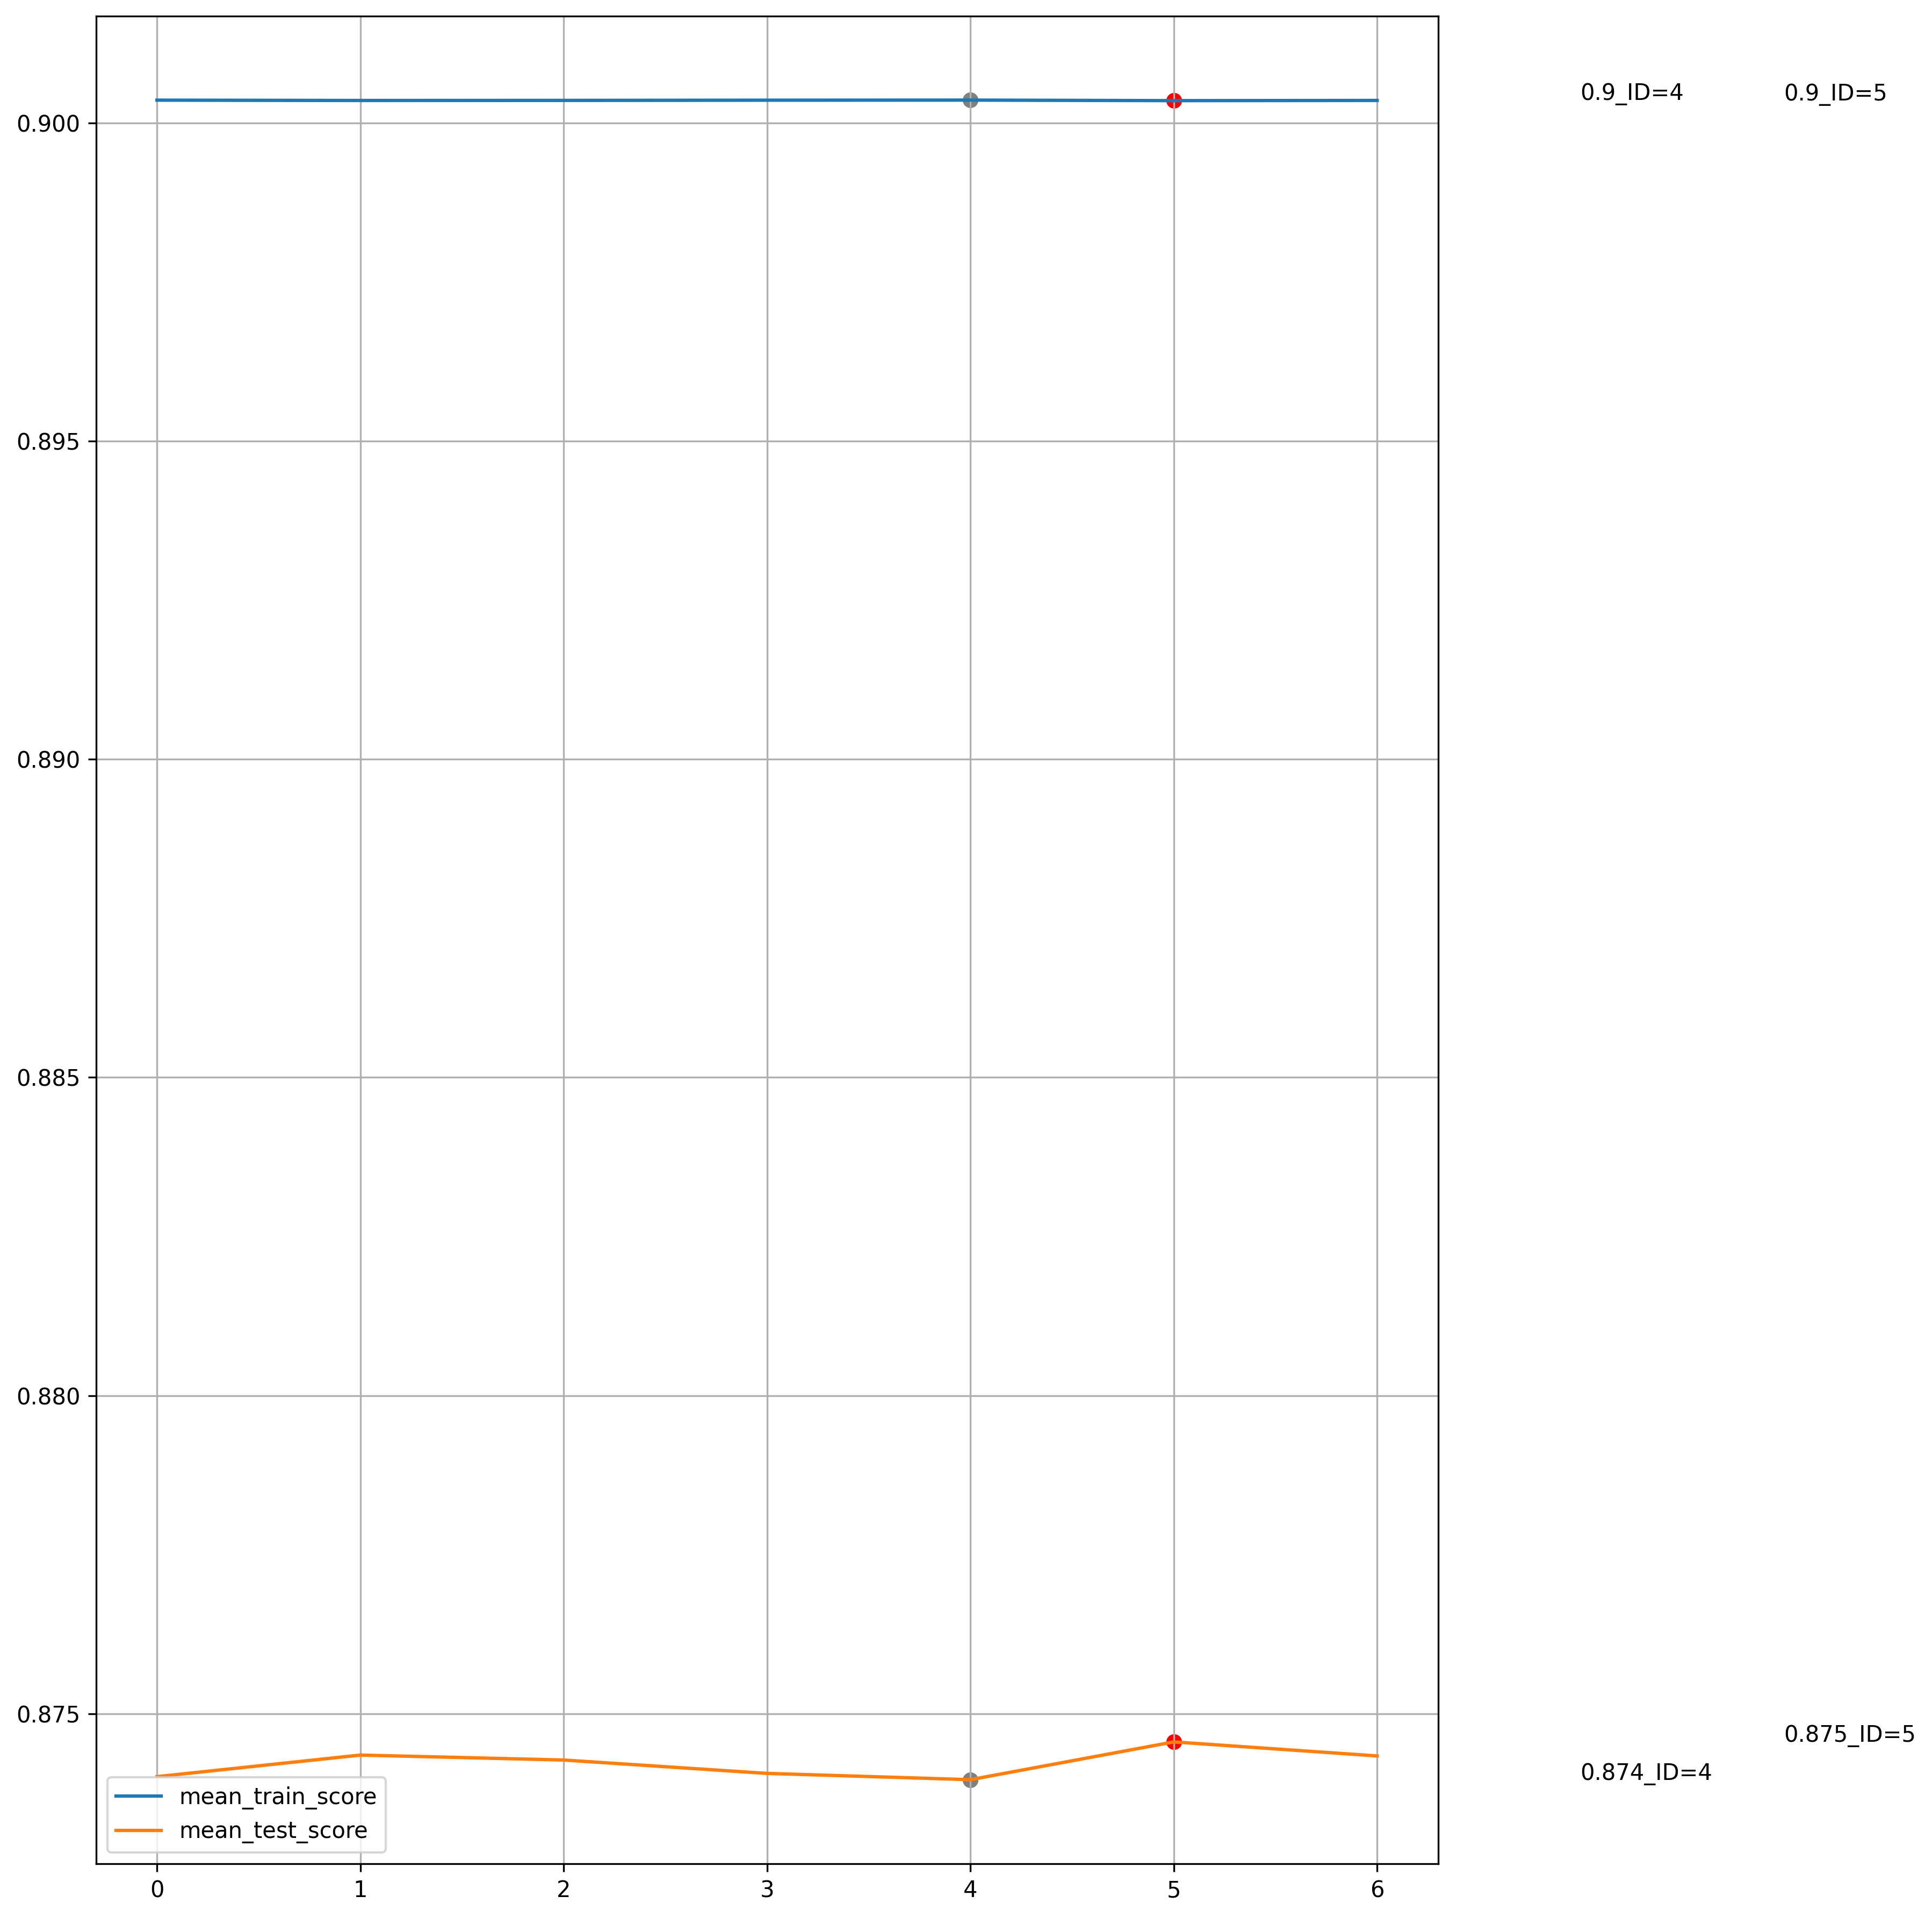

In [23]:
# Hyperparameter tuning
run_grid_search = True  # <--------------- TADY JE POTREBA TO ZAPNOUT (pokud chces tunit)
if run_grid_search:
    import pandas as pd
    from sklearn.model_selection import train_test_split
    class_map = {"benign_2310:unknown": 0, "misp_2310:phishing": 1}
    labels = df['label'].apply(lambda x: class_map[x])
    features = df.drop('label', axis=1).copy()
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import StratifiedKFold
    from lightgbm import LGBMClassifier  # Updated import

    params = {
        "objective": "binary",  # binary classification
        "boosting_type": "gbdt",  # Gradient Boosting Decision Tree
        "n_estimators": 897, # Number of boosted trees to fit, equivalent to number of boosting iterations
        "num_leaves": 59,
        "max_depth": 17,
        "learning_rate": 0.15,
        "objective": "binary",
        "min_child_samples": 27,
        "colsample_bytree": 0.9,
        "reg_lambda": 0.11,
        #"scale_pos_weight": 6.28, # default: 1.0
        "subsample_for_bin": 240000,
        "random_state": 7,
    }


    clf = LGBMClassifier(**params)  # Updated classifier instantiation

    # this is your grid of parameters to search through, every combination will be tried
    grid = {
        'scale_pos_weight': [6.1, 6.28, 6.3, 6.4, 6.5, 6.6, 7],
    }

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=7)
    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=grid,
        #n_jobs=-1,
        cv=cv,
        #scoring='neg_log_loss',#'f1',
        #scoring='f1',#'f1',
        scoring=FETA_Score,
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(X_train, y_train)

    clf = grid_search.best_estimator_

    scores = pd.DataFrame(grid_search.cv_results_)
    col_names = ['mean_train_score', 'mean_test_score']

    scores = pd.DataFrame(grid_search.cv_results_)

    from numpy import array
    from numpy.ma import masked_array

    col_names = ['mean_train_score', 'mean_test_score']
    means_df = scores[col_names]
    ax = means_df.plot(kind='line', grid=True)

    from matplotlib import pyplot as plt
    plt.rcParams["figure.figsize"] = [12, 12]
    plt.rcParams["figure.autolayout"] = True

    plt.rcParams["figure.dpi"] = 300

    max_ids = means_df.idxmax(axis=0)

    for i in range(len(max_ids)):
        for col_name in col_names:
            value = means_df[col_name][max_ids[i]]
            id = max_ids[i]

            color = 'r' if max_ids[i] == max_ids['mean_test_score'] else 'grey'

            ax.scatter([id], [value],
                      marker='o',
                      color=color,
                      label='point',)

            ax.annotate(str(round(value, 3))+"_ID="+str(id),
                        (id, value),
                        xytext=(id+3, value))

    print(scores)

In [24]:
scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scale_pos_weight,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,7.830863,0.079563,8.415899,0.062032,6.1,{'scale_pos_weight': 6.1},0.874164,0.873854,0.874009,0.000155,6,0.900353,0.900374,0.900363,0.000010
1,7.803860,0.077343,8.331629,0.057040,6.28,{'scale_pos_weight': 6.28},0.874687,0.874010,0.874348,0.000338,2,0.900345,0.900371,0.900358,0.000013
2,7.863485,0.081496,8.388739,0.006409,6.3,{'scale_pos_weight': 6.3},0.874393,0.874147,0.874270,0.000123,4,0.900349,0.900369,0.900359,0.000010
3,7.842138,0.083829,8.447124,0.037107,6.4,{'scale_pos_weight': 6.4},0.874251,0.873870,0.874060,0.000190,5,0.900352,0.900373,0.900363,0.000010
4,7.826318,0.062352,8.414502,0.039046,6.5,{'scale_pos_weight': 6.5},0.873876,0.874047,0.873962,0.000086,7,0.900358,0.900370,0.900364,0.000006
5,7.813140,0.075116,8.367081,0.071779,6.6,{'scale_pos_weight': 6.6},0.874539,0.874572,0.874555,0.000017,1,0.900348,0.900363,0.900356,0.000008
6,7.854391,0.101143,8.350054,0.044487,7,{'scale_pos_weight': 7},0.874323,0.874347,0.874335,0.000012,3,0.900351,0.900366,0.900359,0.000007



# Advanced Tuning & Overfitting Prevention

Studies logloss and standard metrics based on variable parameter (e.g. max_depth)

In [97]:
advanced_tuning = True # Allowi

import lightgbm as lgb
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Fixed LightGBM parameters
params = {
    'objective': 'binary',  # binary classification
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'n_estimators': 700,  # Number of boosted trees to fit, equivalent to number of boosting iterations
    #'num_leaves': 86,
    'num_leaves': 40,
    
    'max_depth': 4,
    'random_state': 7,
    'learning_rate': 0.1,
    'min_child_samples': 27,
    #'scale_pos_weight': 1.6,
    'colsample_bytree': 0.9,
    'reg_lambda': 0.1,
    #"num_boost_round": 90,
    'metric': ['error', 'binary_logloss', 'auc'],
}


# Define hatch patterns for different metrics
hatch_patterns = ['/', '\\', 'x', '-']

import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def train_and_evaluate(param_name, param_values):
    # Initialize an empty dictionary to hold the results
    evals_results = {}
    metrics_results = {}

    # Loop over the values of the parameter
    for value in param_values:
        print(f"Training with {param_name}: {value}")
        params[param_name] = value
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train, eval_set=eval_set)
        # Store the evaluation results
        evals_results[value] = model.evals_result_

        # Predict on the testing set
        y_pred = model.predict(X_test)
        # Calculate metrics
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        # Calculate FPR
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fpr = fp / (fp + tn)
        metrics_results[value] = [precision, recall, f1, fpr]

    # Plotting the log loss for different values of the parameter
    plt.rcParams["figure.dpi"] = 300
    plt.figure(figsize=(12, 14))

    # Define color palette for multiple lines
    colors = plt.cm.viridis(np.linspace(0, 1, len(param_values)))

    # First plot (line plot for log loss)
    plt.subplot(2, 1, 1)

    for i, value in enumerate(param_values):
        trees = len(evals_results[value]['valid_1']['binary_logloss'])
        x_axis = range(0, trees)
        plt.plot(x_axis, evals_results[value]['training']['binary_logloss'],
                 label=f'Training {param_name} {value}', color=colors[i])
        plt.plot(x_axis, evals_results[value]['valid_1']['binary_logloss'],
                 label=f'Testing {param_name} {value}', color=colors[i], linestyle='dashed')

    plt.ylabel('Log Loss')
    plt.xlabel('Number of Trees')
    plt.title(f'LightGBM Log Loss for Different {param_name} Values')
    plt.legend()

    # Second plot (bar plot for Precision, Recall, F1, FPR)
    plt.subplot(2, 1, 2)
    bar_width = 0.15  # Smaller width for clearer separation between bars
    index = np.arange(len(param_values)) * 1.2  # Increase space between groups

    for i, metric in enumerate(['Precision', 'Recall', 'F1 Score', 'FPR']):
        scores = [metrics_results[m][i] for m in metrics_results]
        bars = plt.bar(index + i * bar_width, scores, bar_width, label=metric, color=colors,
                hatch=hatch_patterns[i] * 3, edgecolor='black', linewidth=1)

        # Annotate the top of the bars with the metric values
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2),  # Adjust the offset if needed
                     ha='center', va='bottom', color='black', fontsize=8)

    plt.xlabel(param_name)
    plt.xticks(index + bar_width / 2, param_values)
    plt.legend()
    plt.title(f'Precision, Recall, F1 Score, and FPR for Different {param_name} Values')

    plt.tight_layout()
    plt.show()

# Specify the variable parameter name and the list of values
variable_param_name = 'max_depth'  # This can be changed to any other parameter
variable_param_values = [3, 4, 5, 6]  # These values should correspond to the selected parameter

#variable_param_name = 'feature_fraction'  # This can be changed to any other parameter
#variable_param_values = [0.1, 0.5, 0.8, 1.0]  # These values should correspond to the selected parameter

if advanced_tuning:
    # Call the function with the parameter name and values
    train_and_evaluate(variable_param_name, variable_param_values)

Training with max_depth: 3
[LightGBM] [Info] Number of positive: 47847, number of negative: 302800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.236412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13408
[LightGBM] [Info] Number of data points in the train set: 350647, number of used features: 141
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.136453 -> initscore=-1.845064
[LightGBM] [Info] Start training from score -1.845064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training with max_depth: 4
[LightGBM] [Info] Number of positive: 47847, number of negative: 302800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.247824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13408
[LightGBM] [Info] Number of data points in the train set: 350647, number of used features: 141
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.136453 -> initscore=-1.845064
[LightGBM] [Info] Start training from score -1.845064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

KeyboardInterrupt: 

# Feature Importance Analysis

In [27]:
class_map = {"benign_2310:unknown": 0, "misp_2311:phishing": 1}
class_names=class_map.values()

# initialize shap
import shap
# get shap values (use a smaller sample of the test set if you want to save coffee)
explainer = shap.TreeExplainer(model)
X_sample = X_test
shap_values = explainer.shap_values(X_sample)
# save the values for later use
import pickle
pickle.dump(shap_values, open("shap_values_gbm.pickle.dat", "wb"))


# load the values to start from here
import pickle
shap_values = pickle.load(open("shap_values_gbm.pickle.dat", "rb"))

import shap
shap.initjs()
reverse_class_map = {v: k for k, v in class_map.items()}

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [28]:
# 1. Extract SHAP values for the positive class
positive_class_shap_values = shap_values[1]

# 2. Adjust the plot_shap function
import ipywidgets as widgets
from ipywidgets import interact
plot_type = widgets.RadioButtons(
    options=['dot', 'layered_violin', 'bar'],
    value='layered_violin',
    description='Plot Type:',
    disabled=False
)
max_display = widgets.IntSlider(
    value=10,
    description='Max Display:',
    disabled=False,
    min=1,
    max=len(X_sample.columns)-1
)

@interact
def plot_shap(plot_type=plot_type, max_display=max_display):
    shap.summary_plot(positive_class_shap_values, X_sample, show=False, plot_type=plot_type, class_names=list(class_map.values()), max_display=max_display, plot_size=[10, max_display])
    plt.savefig("shap_summary_icc.pdf")


interactive(children=(RadioButtons(description='Plot Type:', index=1, options=('dot', 'layered_violin', 'bar')…

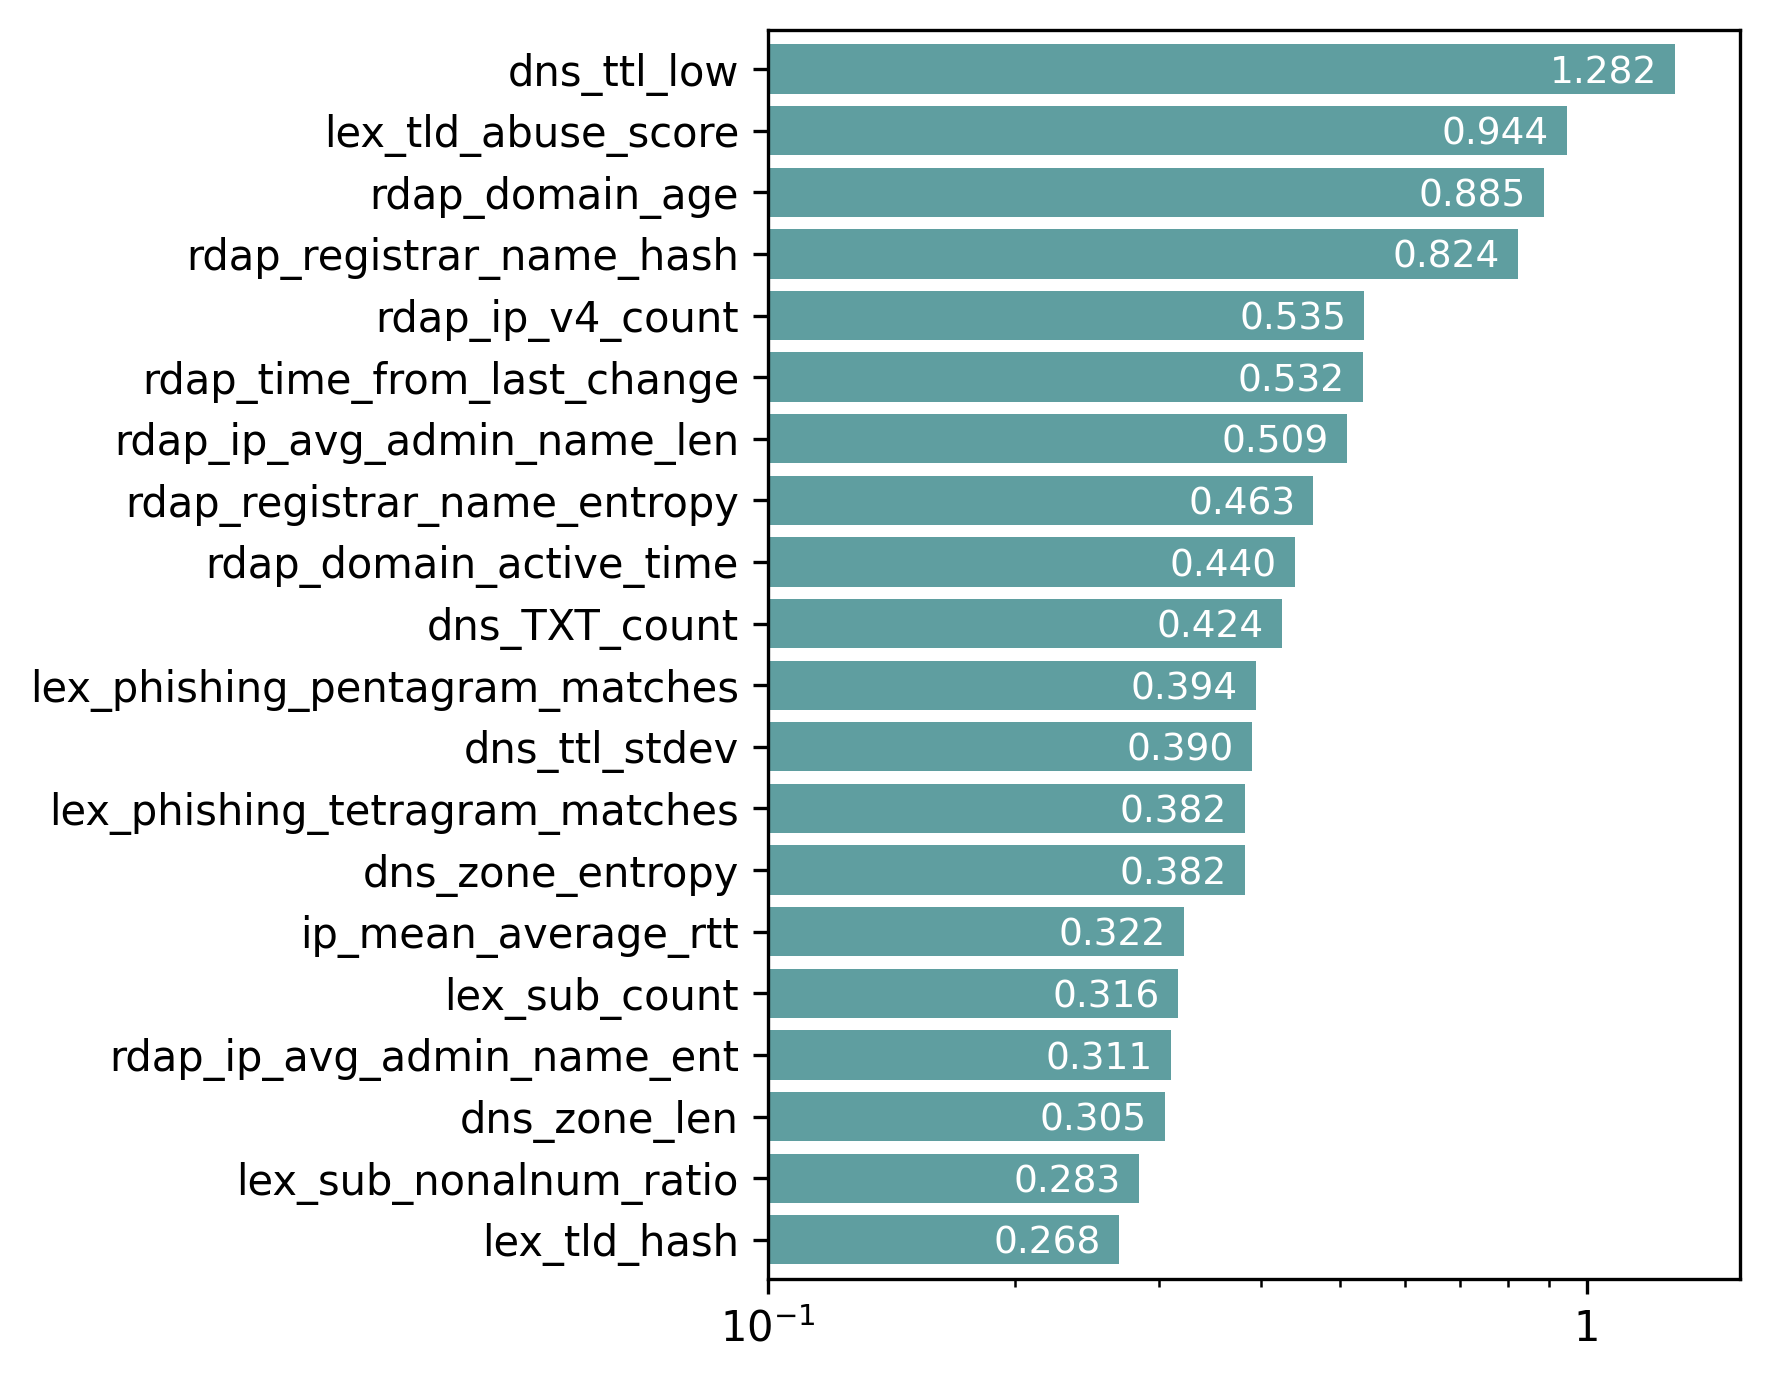

In [30]:
import numpy as np
import matplotlib.pyplot as plt

max_display=20
X_sample = X_test
shap_values = positive_class_shap_values

# Calculate mean absolute shap values
mean_shap_values = np.mean(np.abs(shap_values), axis=0)

# Sort them
sorted_indices = np.argsort(mean_shap_values)

# Consider the top 'max_display' features
top_indices = sorted_indices[-max_display:]

# Custom bar height and spacing
bar_height = 0.12
spacing = 0.15
y_positions = np.arange(max_display) * spacing

colors = 'cadetblue'

plt.figure(figsize=(6, 4.7))

# Plotting the bars
bars = plt.barh(y_positions, mean_shap_values[top_indices], height=bar_height, align='center', color=colors)

# Add textual values on each bar
for bar in bars:
    xval = bar.get_width()
    label_text = f'{xval:.3f}'
    
    plt.text(xval - (0.05 * xval), bar.get_y() + bar.get_height()/2 - 0.01, label_text, 
             ha='right', va='center', color='white', fontsize=9)

plt.yticks(y_positions, X_sample.columns[top_indices])
plt.ylim(y_positions[0] - 0.095, y_positions[-1] + 0.095)
plt.xscale('log')
locs, labels = plt.xticks()
new_labels = [str(int(loc)) if loc == 1 or loc == 0.1 else label.get_text() for loc, label in zip(locs, labels)]
plt.xticks(locs, new_labels)
max_shap_value = np.max(mean_shap_values[top_indices])
plt.xlim(0.1, max_shap_value*1.2)

plt.tight_layout()
plt.savefig("shap_summary_bar_gbm_asiaccs.pdf")
plt.show()


In [31]:
top_features = X_sample.columns[top_indices]

# Count the number of features in each category among the top 20
category_counts = {}
prefixes = ["lex_", "dns_", "ip_", "tls_", "rdap_", "geo_"]

for prefix in prefixes:
    category_counts[prefix] = sum([1 for feature in top_features if feature.startswith(prefix)])

print(category_counts)

{'lex_': 6, 'dns_': 5, 'ip_': 1, 'tls_': 0, 'rdap_': 8, 'geo_': 0}


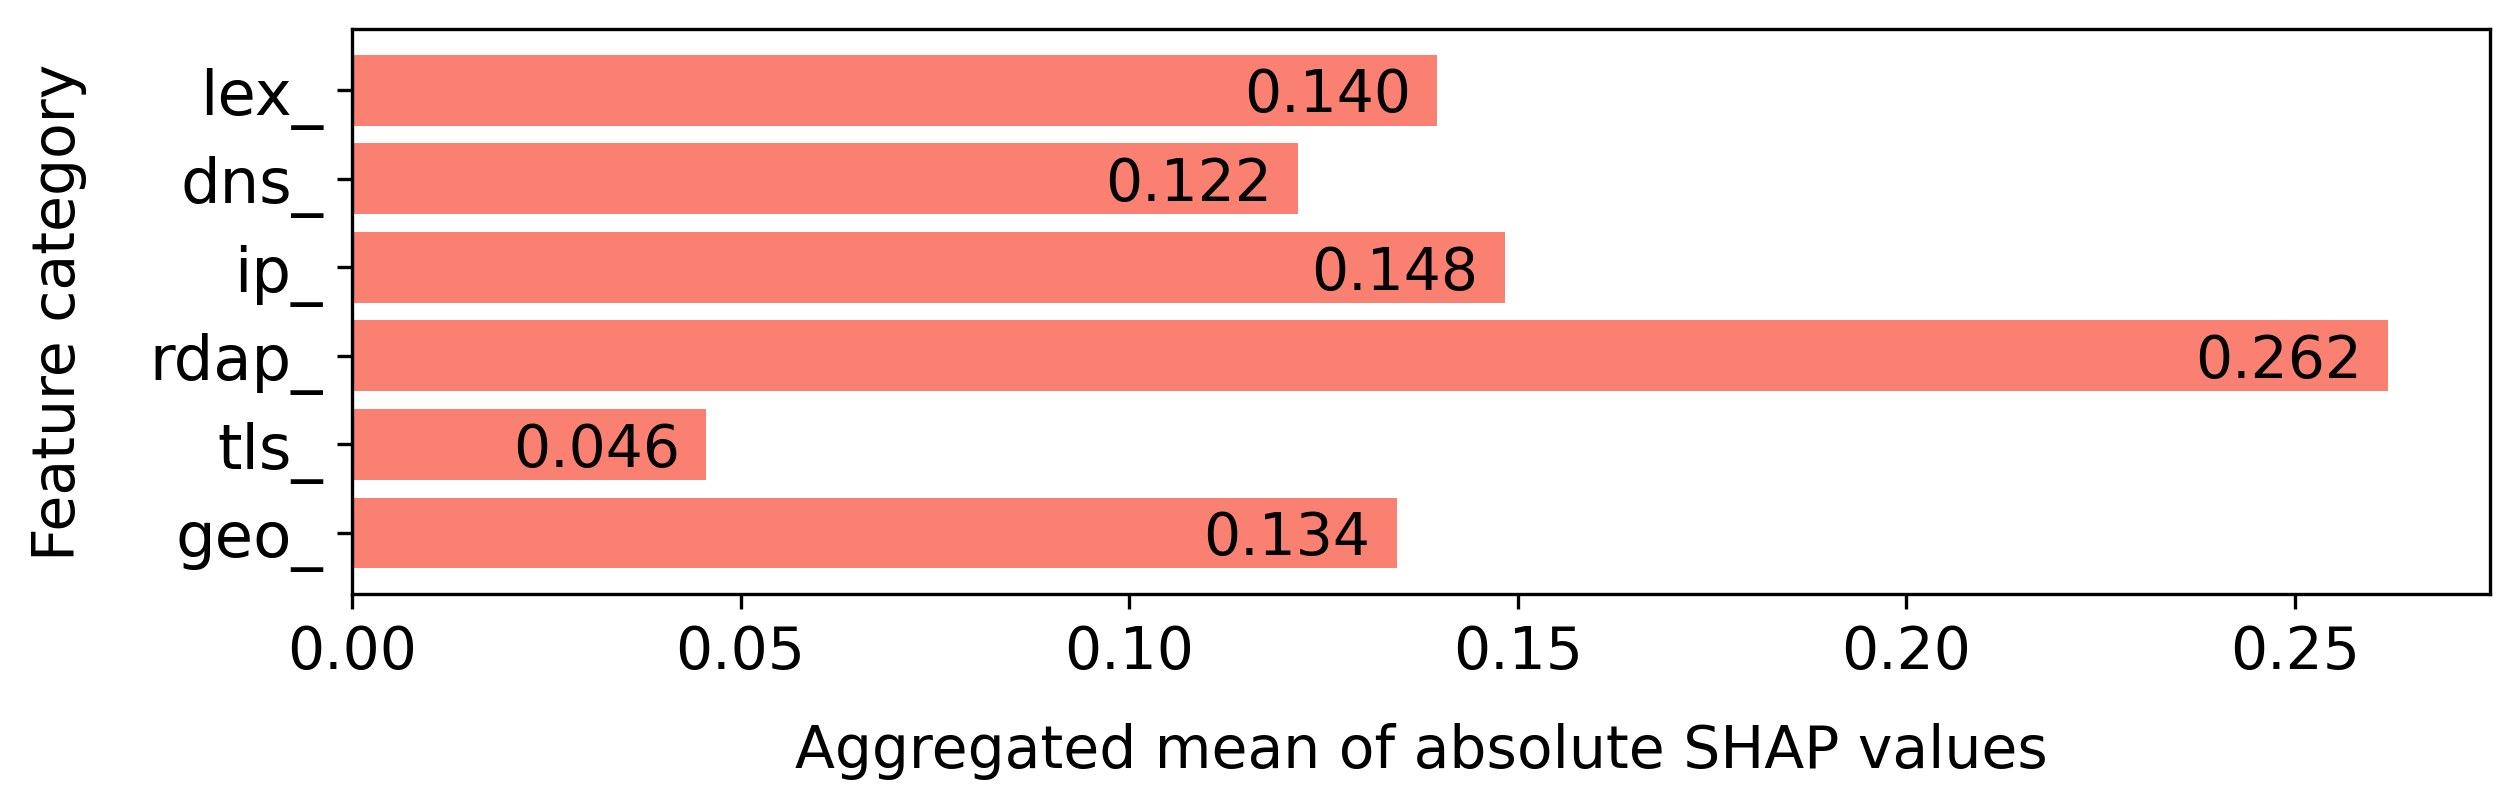

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for customization
bar_height = 0.12  # Height of each bar
spacing = 0.15  # Vertical spacing between bars
padding = 0.05  # Vertical space before the first bar and after the last bar

shap_values = positive_class_shap_values

# Calculate mean absolute shap values for each feature
mean_shap_values = np.mean(np.abs(shap_values), axis=0)

# List of feature prefixes
prefixes = ["lex_", "dns_", "ip_", "rdap_", "tls_", "geo_"]

# Dictionary to hold the aggregated mean for each prefix
aggregated_means = {}

# Compute mean of absolute SHAP values for each prefix
for prefix in prefixes:
    indices = [i for i, col_name in enumerate(X_sample.columns) if col_name.startswith(prefix)]
    group_mean_shap = [mean_shap_values[i] for i in indices]
    aggregated_means[prefix] = np.mean(group_mean_shap)

# Sort prefixes and their values by importance
#sorted_prefixes = sorted(aggregated_means, key=aggregated_means.get, reverse=False)
sorted_prefixes = list(reversed(prefixes))

sorted_prefix_values = [aggregated_means[prefix] for prefix in sorted_prefixes]

# Create the y positions for each bar
y_positions = np.arange(len(sorted_prefixes)) * spacing + padding

plt.figure(figsize=(8.5, 2.8))

# Create horizontal bar chart with adjustable bar height and spacing
bars = plt.barh(y_positions, sorted_prefix_values, color='salmon', height=bar_height)

# Customizing the chart with increased font size
plt.xlabel('Aggregated mean of absolute SHAP values', fontsize=14, labelpad=10)
plt.ylabel('Feature category', fontsize=14, labelpad=15)
plt.yticks(y_positions, sorted_prefixes, fontsize=15)
plt.xticks(fontsize=14)

# Display values on the bars with two decimal places
for bar, y_pos in zip(bars, y_positions):
    xval = bar.get_width()
    plt.text(xval - 0.013 * max(sorted_prefix_values), y_pos - 0.008, "{:.3f}".format(xval), ha='right', va='center', fontsize=14, color='black')

plt.tight_layout()

# Save and show the chart
plt.savefig("aggregated_shap_gbm_horizontal.pdf")
plt.show()


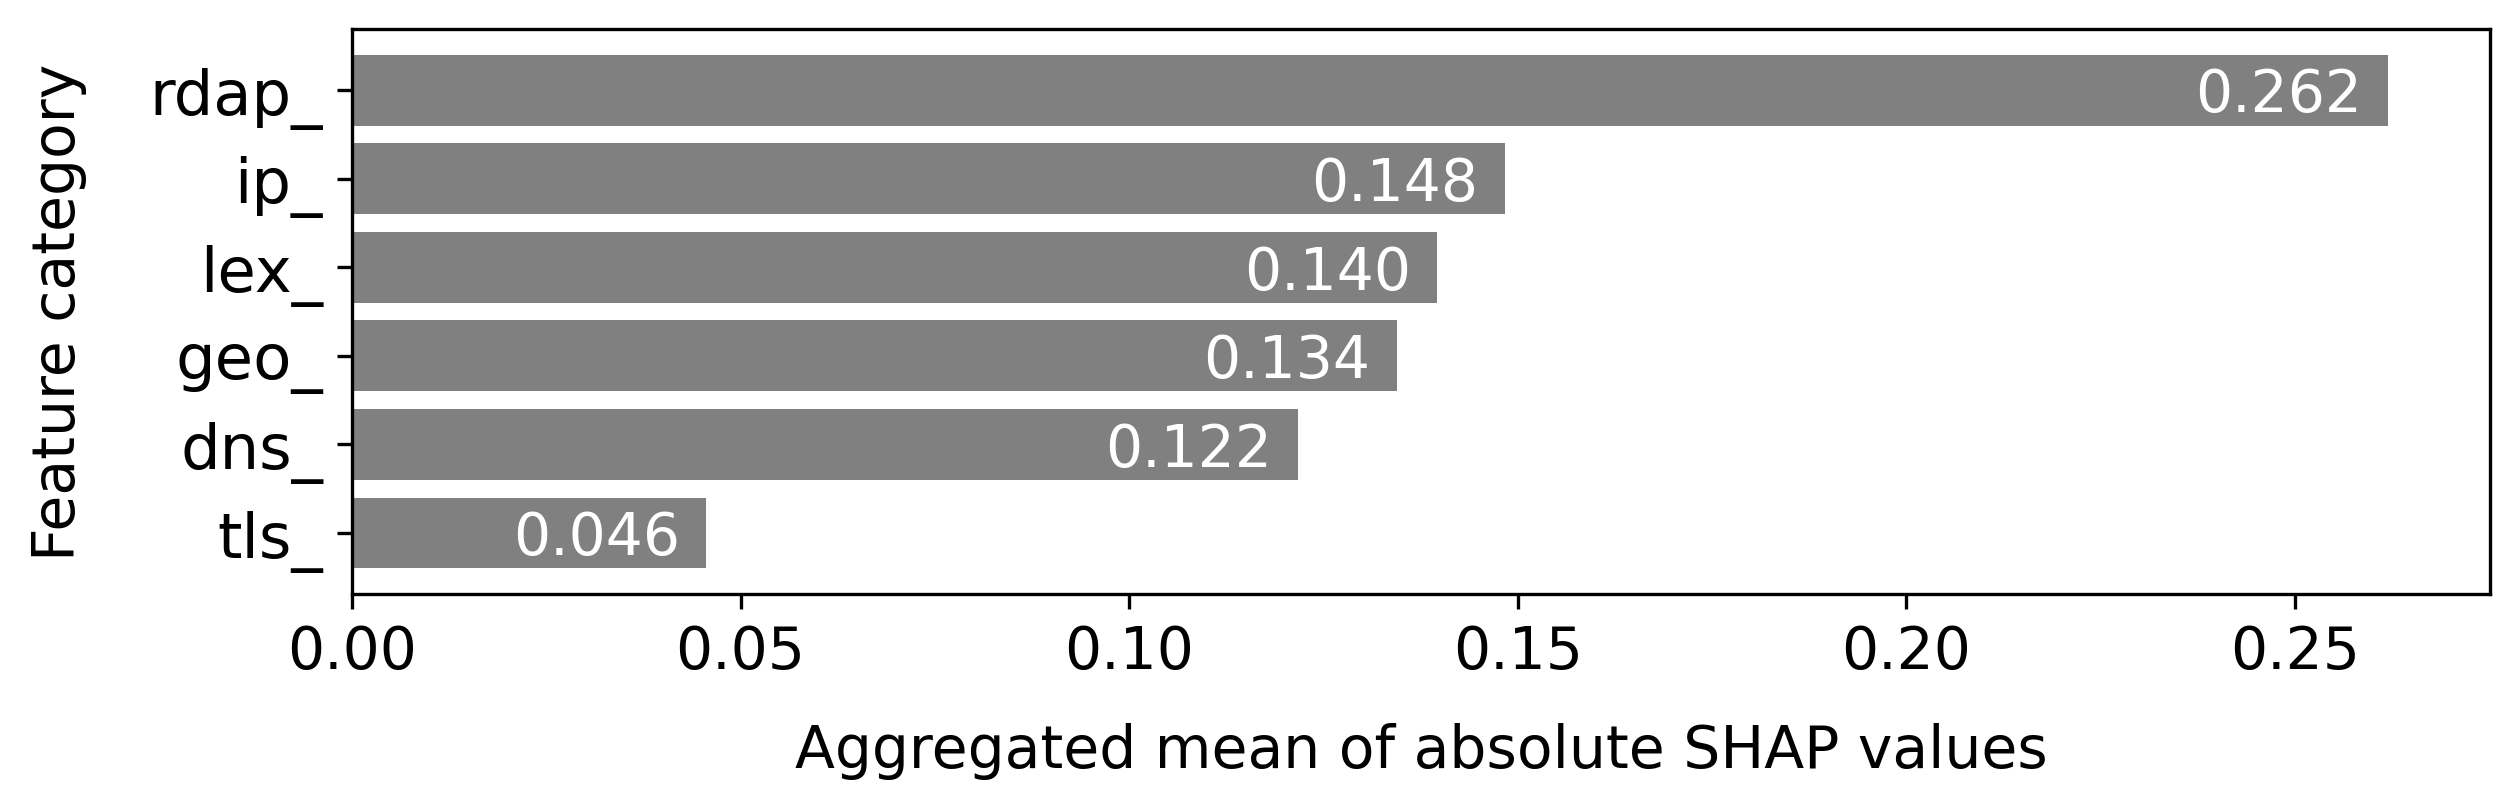

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for customization
bar_height = 0.12  # Height of each bar
spacing = 0.15  # Vertical spacing between bars
padding = 0.05  # Vertical space before the first bar and after the last bar

shap_values = positive_class_shap_values

# Calculate mean absolute shap values for each feature
mean_shap_values = np.mean(np.abs(shap_values), axis=0)

# List of feature prefixes
prefixes = ["lex_", "dns_", "ip_", "rdap_", "tls_", "geo_"]
prefixes = ["rdap_", "ip_", "lex_", "geo_", "dns_", "tls_"]

# Dictionary to hold the aggregated mean for each prefix
aggregated_means = {}

# Compute mean of absolute SHAP values for each prefix
for prefix in prefixes:
    indices = [i for i, col_name in enumerate(X_sample.columns) if col_name.startswith(prefix)]
    group_mean_shap = [mean_shap_values[i] for i in indices]
    aggregated_means[prefix] = np.mean(group_mean_shap)

# Sort prefixes and their values by importance
#sorted_prefixes = sorted(aggregated_means, key=aggregated_means.get, reverse=False)
sorted_prefixes = list(reversed(prefixes))

sorted_prefix_values = [aggregated_means[prefix] for prefix in sorted_prefixes]

# Create the y positions for each bar
y_positions = np.arange(len(sorted_prefixes)) * spacing + padding

plt.figure(figsize=(8.5, 2.8))

# Create horizontal bar chart with adjustable bar height and spacing
bars = plt.barh(y_positions, sorted_prefix_values, color='grey', height=bar_height)

# Customizing the chart with increased font size
plt.xlabel('Aggregated mean of absolute SHAP values', fontsize=14, labelpad=10)
plt.ylabel('Feature category', fontsize=14, labelpad=15)
plt.yticks(y_positions, sorted_prefixes, fontsize=15)
plt.xticks(fontsize=14)

# Display values on the bars with two decimal places
for bar, y_pos in zip(bars, y_positions):
    xval = bar.get_width()
    plt.text(xval - 0.013 * max(sorted_prefix_values), y_pos - 0.008, "{:.3f}".format(xval), ha='right', va='center', fontsize=14, color='white')

plt.tight_layout()

# Save and show the chart
plt.savefig("aggregated_shap_gbm_horizontal.pdf")
plt.show()


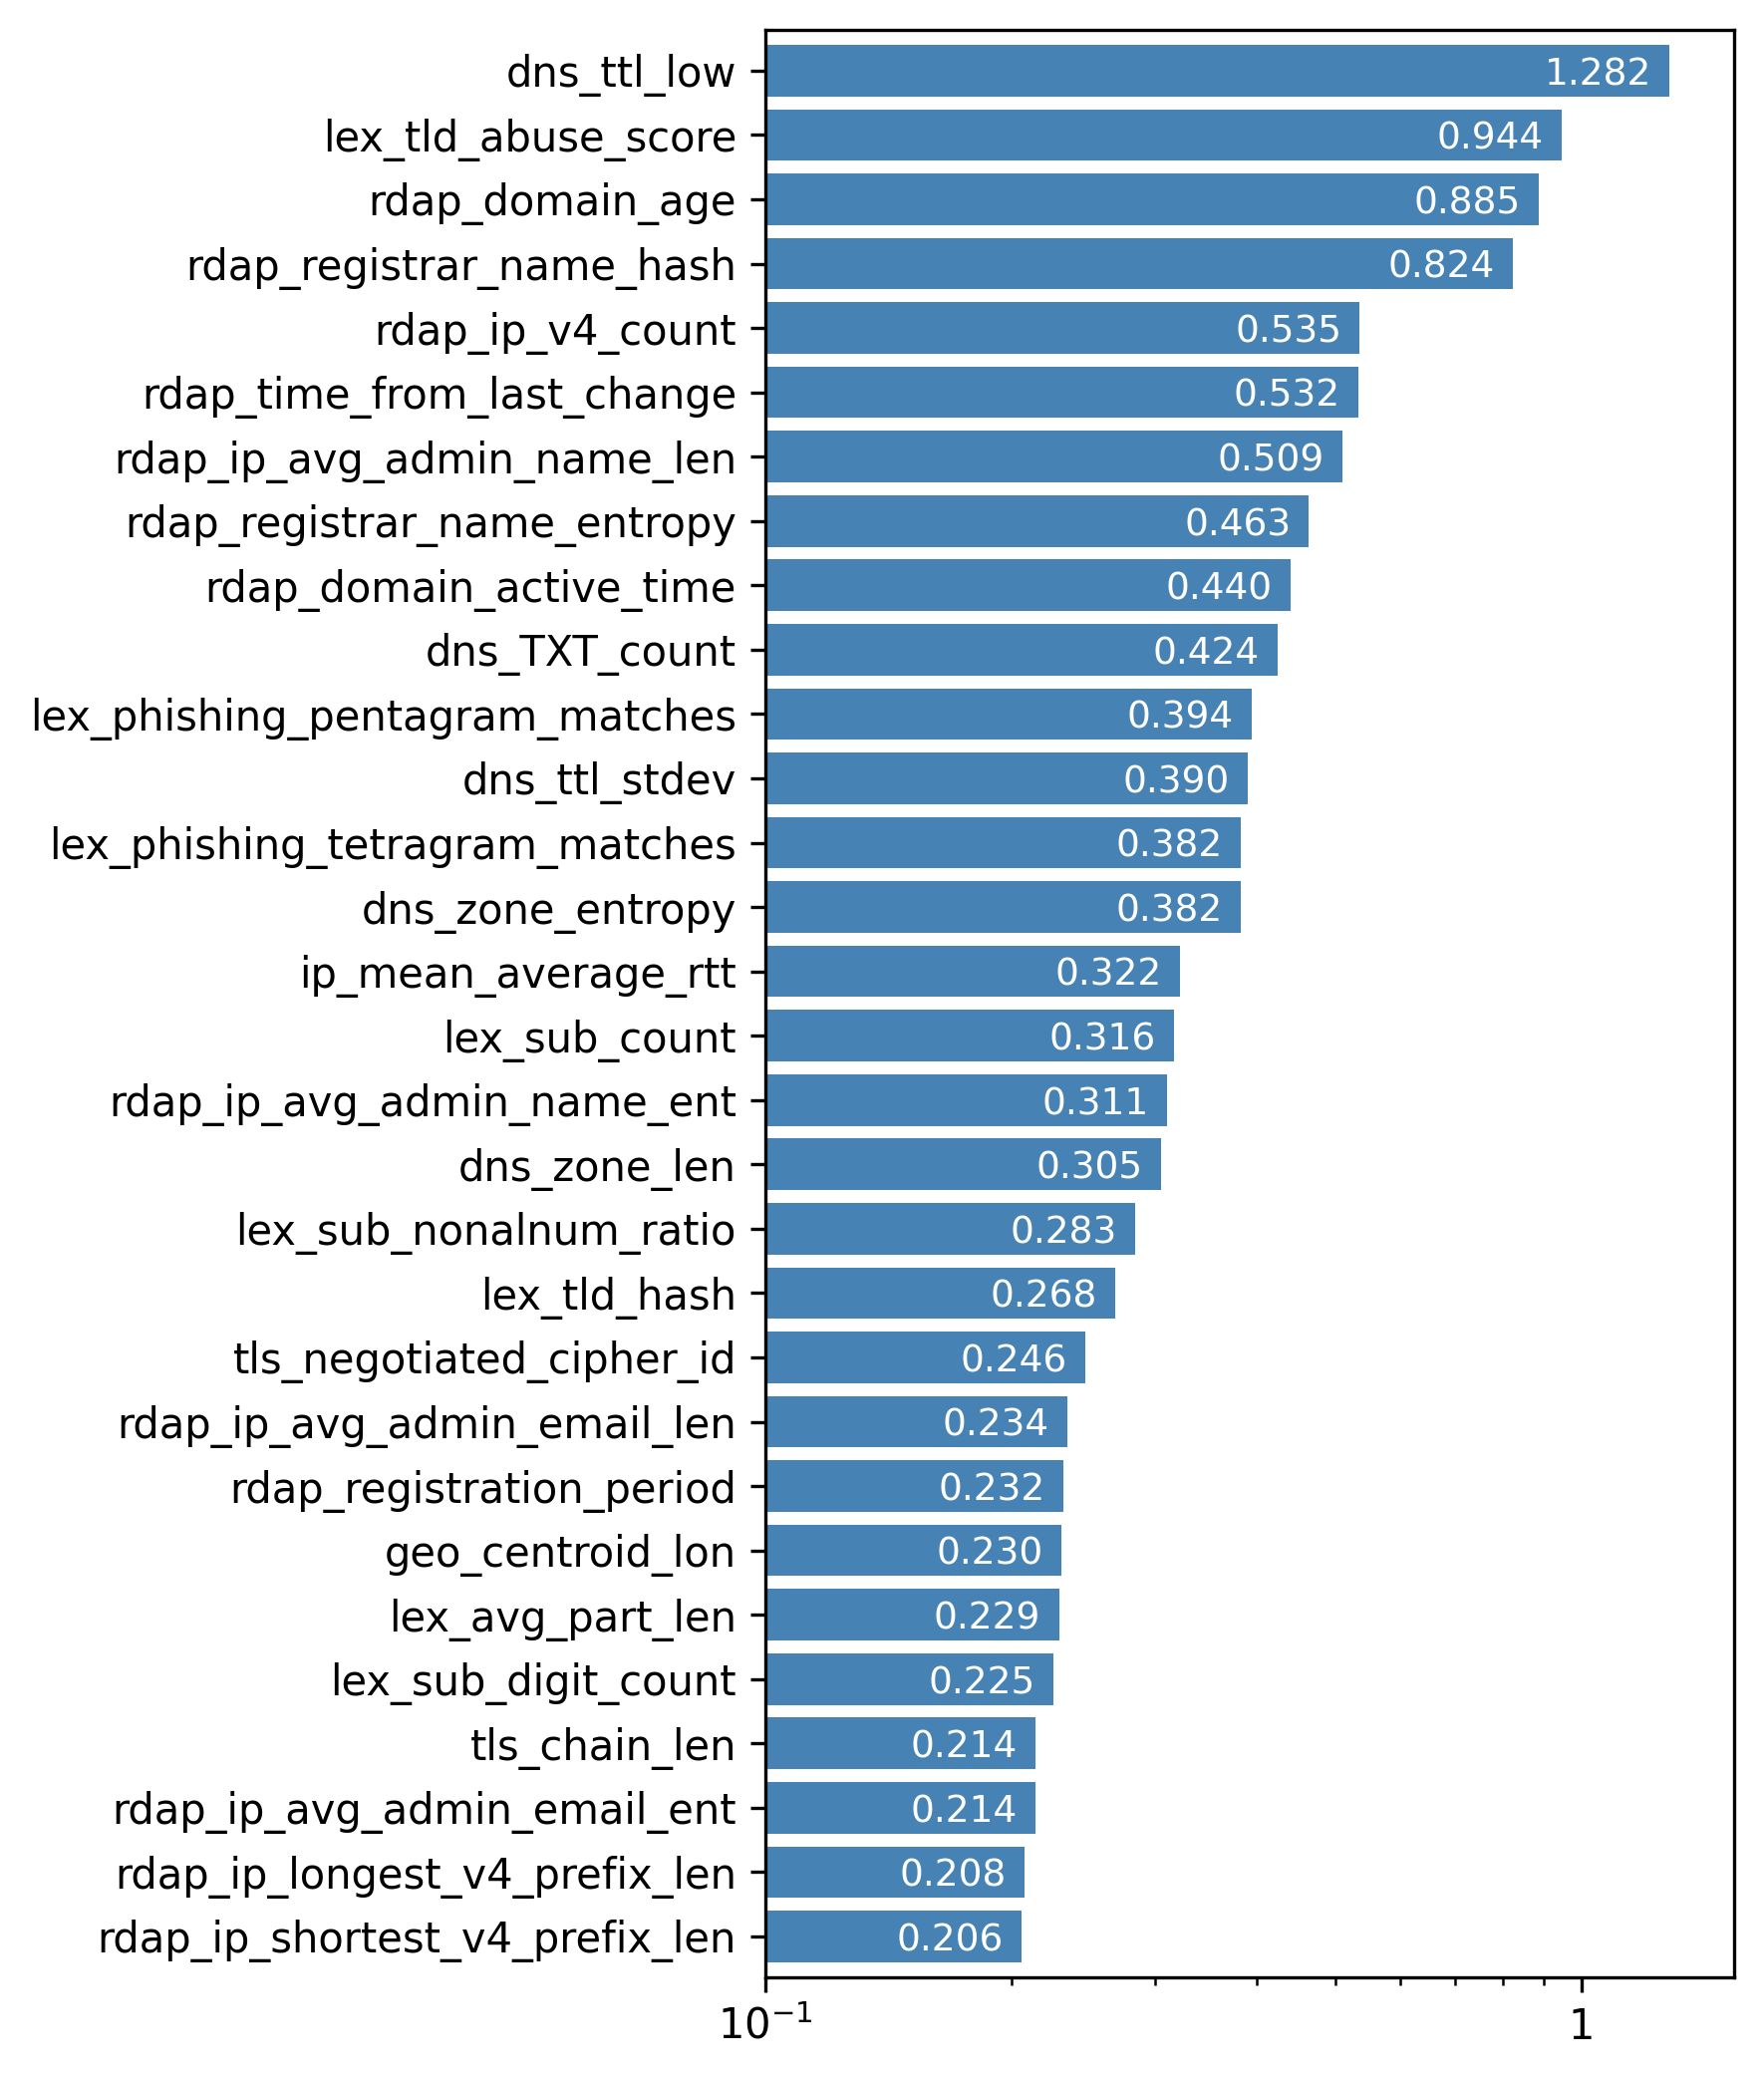

In [39]:
import numpy as np
import matplotlib.pyplot as plt

max_display=30
X_sample = X_test
shap_values = positive_class_shap_values

# Calculate mean absolute shap values
mean_shap_values = np.mean(np.abs(shap_values), axis=0)

# Sort them
sorted_indices = np.argsort(mean_shap_values)

# Consider the top 'max_display' features
top_indices = sorted_indices[-max_display:]

# Custom bar height and spacing
bar_height = 0.12
spacing = 0.15
y_positions = np.arange(max_display) * spacing

colors = 'steelblue'

plt.figure(figsize=(6, 7.05))

# Plotting the bars
bars = plt.barh(y_positions, mean_shap_values[top_indices], height=bar_height, align='center', color=colors)

# Add textual values on each bar
for bar in bars:
    xval = bar.get_width()
    label_text = f'{xval:.3f}'
    
    plt.text(xval - (0.05 * xval), bar.get_y() + bar.get_height()/2 - 0.01, label_text, 
             ha='right', va='center', color='white', fontsize=9)

plt.yticks(y_positions, X_sample.columns[top_indices])
plt.ylim(y_positions[0] - 0.095, y_positions[-1] + 0.095)
plt.xscale('log')
locs, labels = plt.xticks()
new_labels = [str(int(loc)) if loc == 1 or loc == 0.1 else label.get_text() for loc, label in zip(locs, labels)]
plt.xticks(locs, new_labels)
max_shap_value = np.max(mean_shap_values[top_indices])
plt.xlim(0.1, max_shap_value*1.2)

plt.tight_layout()
plt.savefig("shap_summary_bar_gbm_asiaccs_30.pdf")
plt.show()


Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


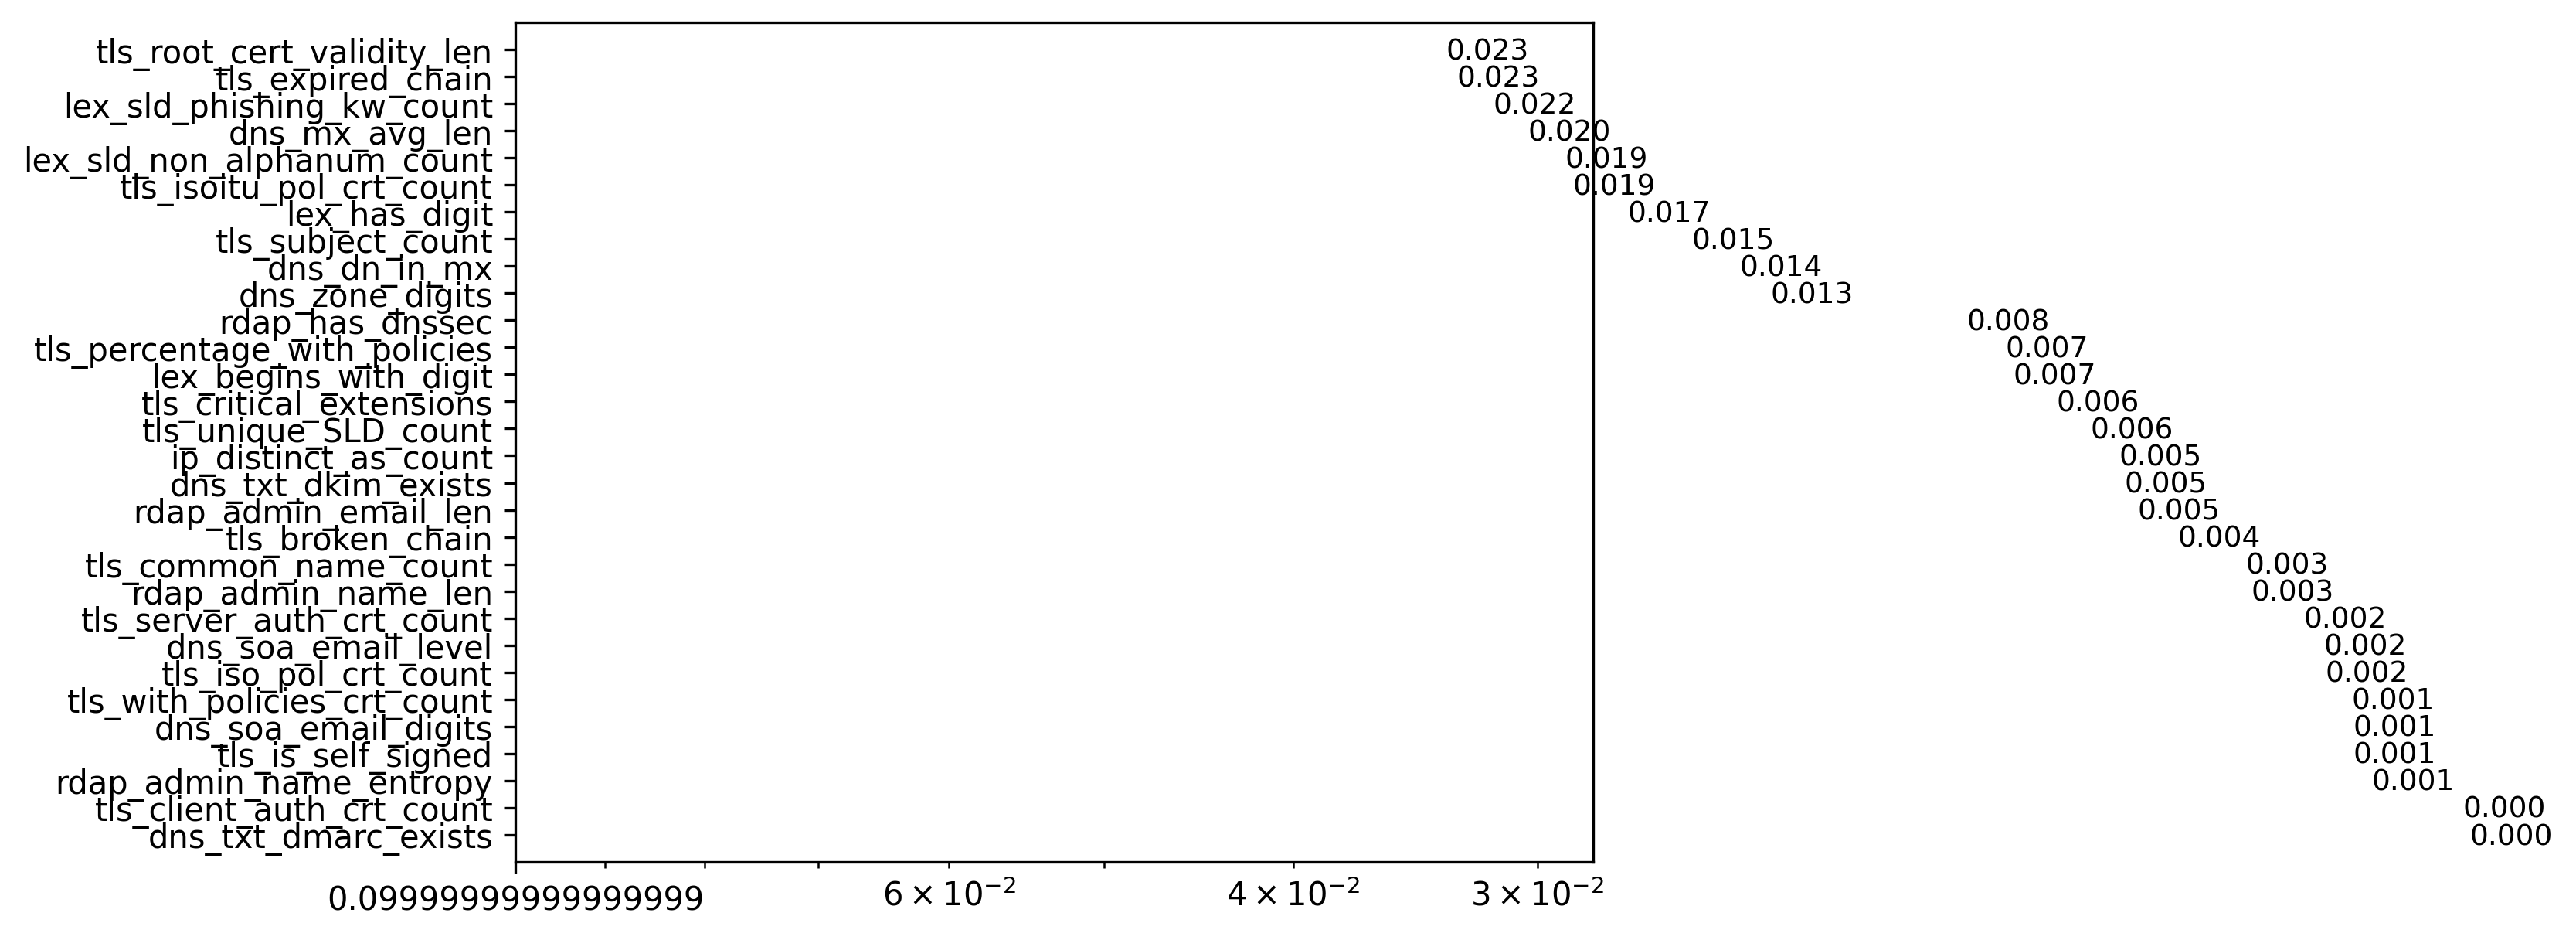

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

shap_values = positive_class_shap_values
X_sample = X_test

max_display = 30

# Calculate mean absolute shap values
mean_shap_values = np.mean(np.abs(shap_values), axis=0)

# Sort them
sorted_indices = np.argsort(mean_shap_values)

# Consider the least important 'max_display' features
least_important_indices = sorted_indices[:max_display]

# Custom bar height and spacing
bar_height = 0.12
spacing = 0.15
y_positions = np.arange(max_display) * spacing

colors = 'steelblue'

plt.figure(figsize=(6, 4.7))

# Plotting the bars for least important features
least_important_bars = plt.barh(y_positions, mean_shap_values[least_important_indices], height=bar_height, align='center', color=colors)

# Add textual values on each bar for least important features
for bar in least_important_bars:
    xval = bar.get_width()
    label_text = f'{xval:.3f}'
    
    plt.text(xval + 0.01, bar.get_y() + bar.get_height()/2 - 0.01, label_text, 
             ha='left', va='center', color='black', fontsize=9)

plt.yticks(y_positions, X_sample.columns[least_important_indices])
plt.ylim(y_positions[0] - spacing, y_positions[-1] + spacing)
plt.xscale('log')
locs, labels = plt.xticks()
new_labels = [str(loc) for loc in locs]
plt.xticks(locs, new_labels)
max_shap_value = np.max(mean_shap_values[least_important_indices])
plt.xlim(0.1, max_shap_value * 1.2)

plt.tight_layout()
plt.show()


# GAIN SCORE

In [35]:
import numpy as np

# Assuming `model` is an instance of LGBMClassifier and has been fitted to your data
gain_importances = model.booster_.feature_importance(importance_type='gain')

# Feature names for each importance
feature_names = model.feature_name_

# Create a list of tuples (feature_name, importance)
feature_importances = [(feature, importance) for feature, importance in zip(feature_names, gain_importances)]

# Sort the feature importances by the gain score, in descending order
sorted_score = sorted(feature_importances, key=lambda x: x[1], reverse=True)
sorted_score


[('rdap_domain_age', 635576.0441587791),
 ('rdap_registrar_name_hash', 273375.1170532629),
 ('dns_zone_entropy', 243652.63786438853),
 ('lex_tld_abuse_score', 130400.98845174164),
 ('rdap_time_from_last_change', 114872.50717546046),
 ('rdap_registrar_name_entropy', 110137.75904350355),
 ('lex_phishing_tetragram_matches', 97465.6526535675),
 ('dns_zone_len', 89101.78150701523),
 ('lex_phishing_pentagram_matches', 87269.77586149424),
 ('rdap_ip_v4_count', 68769.58837063238),
 ('dns_ttl_low', 50096.21048435196),
 ('rdap_ip_avg_admin_email_ent', 43854.374393146485),
 ('lex_avg_part_len', 41189.27623016015),
 ('lex_tld_hash', 37786.045677725226),
 ('rdap_registration_period', 36283.17552281171),
 ('rdap_registrant_name_entropy', 36271.53999812156),
 ('ip_mean_average_rtt', 35229.84894232452),
 ('dns_ttl_stdev', 28436.40760562569),
 ('rdap_domain_active_time', 27232.99057939276),
 ('dns_TXT_count', 26012.77001747489),
 ('lex_sld_len', 24924.247924655676),
 ('rdap_registrant_name_len', 24504.

In [36]:
X_test.head()
X_test.columns

Index(['ip_mean_average_rtt', 'ip_entropy', 'ip_count', 'ip_v4_ratio',
       'ip_as_address_entropy', 'ip_asn_entropy', 'ip_distinct_as_count',
       'dns_A_count', 'dns_AAAA_count', 'dns_MX_count',
       ...
       'rdap_ip_avg_admin_email_ent', 'geo_countries_count',
       'geo_continent_hash', 'geo_countries_hash', 'geo_lat_stdev',
       'geo_lon_stdev', 'geo_mean_lat', 'geo_mean_lon', 'geo_centroid_lat',
       'geo_centroid_lon'],
      dtype='object', length=143)

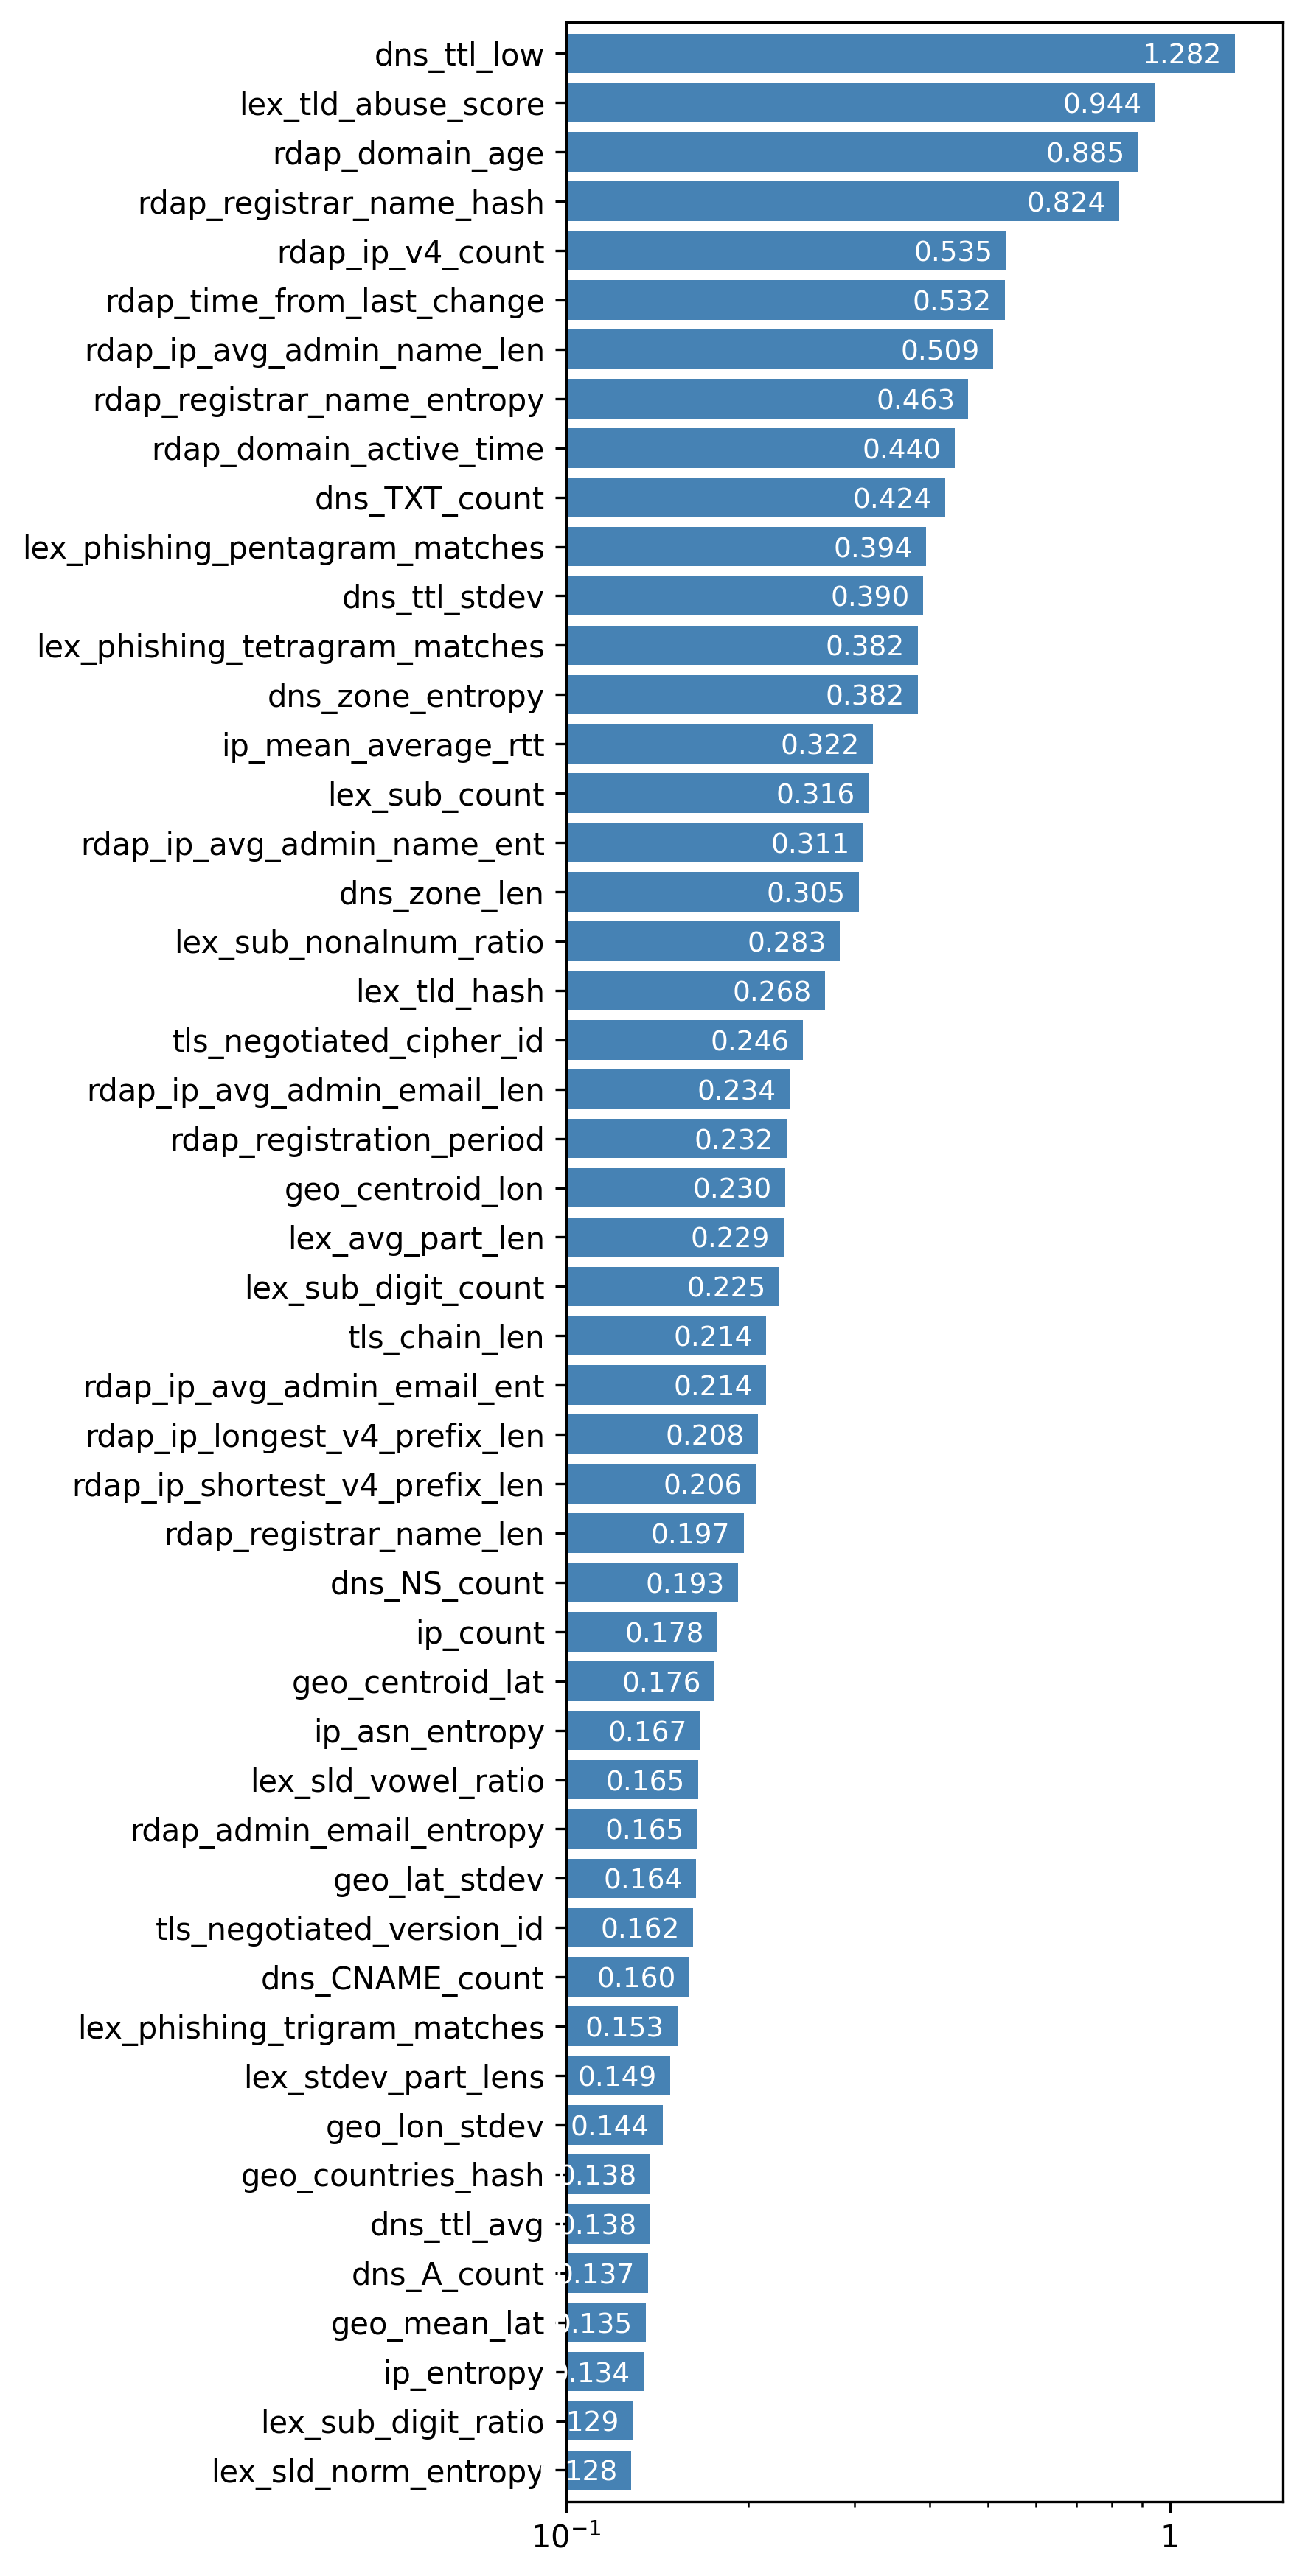

In [37]:
import numpy as np
import matplotlib.pyplot as plt

max_display=50
X_sample = X_test
shap_values = positive_class_shap_values

# Calculate mean absolute shap values
mean_shap_values = np.mean(np.abs(shap_values), axis=0)

# Sort them
sorted_indices = np.argsort(mean_shap_values)

# Consider the top 'max_display' features
top_indices = sorted_indices[-max_display:]

# Custom bar height and spacing
bar_height = 0.12
spacing = 0.15
y_positions = np.arange(max_display) * spacing

colors = 'steelblue'

plt.figure(figsize=(6, 11.75))

# Plotting the bars
bars = plt.barh(y_positions, mean_shap_values[top_indices], height=bar_height, align='center', color=colors)

# Add textual values on each bar
for bar in bars:
    xval = bar.get_width()
    label_text = f'{xval:.3f}'
    
    plt.text(xval - (0.05 * xval), bar.get_y() + bar.get_height()/2 - 0.01, label_text, 
             ha='right', va='center', color='white', fontsize=9)

plt.yticks(y_positions, X_sample.columns[top_indices])
plt.ylim(y_positions[0] - 0.095, y_positions[-1] + 0.095)
plt.xscale('log')
locs, labels = plt.xticks()
new_labels = [str(int(loc)) if loc == 1 or loc == 0.1 else label.get_text() for loc, label in zip(locs, labels)]
plt.xticks(locs, new_labels)
max_shap_value = np.max(mean_shap_values[top_indices])
plt.xlim(0.1, max_shap_value*1.2)

plt.tight_layout()
plt.savefig("shap_summary_bar_gbm_icc.pdf")
plt.show()
